In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e6/sample_submission.csv
/kaggle/input/playground-series-s3e6/train.csv
/kaggle/input/playground-series-s3e6/test.csv


# If you like it! give upvote

# **1.Loading Libraries**

In [2]:
# !pip install autoviz

In [3]:
# !pip install -U --pre pycaret

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skopt import BayesSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from autoviz.classify_method import data_cleaning_suggestions ,data_suggestions
# from pycaret  import regression
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [5]:
import warnings
warnings.filterwarnings('ignore')

# **2.Read Data**

In [6]:
train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
train = train.drop('id' ,axis = 1)
test  = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')

In [7]:
train.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


# **3.EDA**

## ***3.1 Checking Null***

In [8]:
train.isna().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

# ***3.2 Summary of data***

In [9]:
# data_cleaning_suggestions(train)

# ***3.3descriptive statistics***

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
squareMeters,22730.0,4.658622e+04,4.952124e+04,89.0,20392.75,44484.0,71547.0,6071330.0
numberOfRooms,22730.0,4.824109e+01,2.822643e+01,1.0,25.00,47.0,75.0,100.0
hasYard,22730.0,4.758909e-01,4.994294e-01,0.0,0.00,0.0,1.0,1.0
hasPool,22730.0,4.527497e-01,4.977733e-01,0.0,0.00,0.0,1.0,1.0
floors,22730.0,4.730598e+01,4.777721e+01,1.0,25.00,45.0,69.0,6000.0
cityCode,22730.0,5.001380e+04,3.000664e+04,3.0,22936.00,50414.0,76291.0,491100.0
cityPartRange,22730.0,5.585042e+00,2.739533e+00,1.0,3.00,6.0,8.0,10.0
numPrevOwners,22730.0,5.620766e+00,2.713026e+00,1.0,3.00,6.0,8.0,10.0
made,22730.0,2.008005e+03,1.188268e+02,1990.0,2000.00,2006.0,2014.0,10000.0
isNewBuilt,22730.0,4.679718e-01,4.989841e-01,0.0,0.00,0.0,1.0,1.0


# **3.4 Detecting outlier**

## ***3.4.1 Detecting Oulier Percentage***

In [11]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        q1 = np.quantile(data[column], 0.25)
        q3 = np.quantile(data[column], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_percent = (outliers.shape[0] / data.shape[0]) * 100
        outlier_percents[column] = outlier_percent
        
    outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage')


detect_outliers(train)

,Outlier_percentage
price,0.000000
numberOfRooms,0.000000
hasYard,0.000000
hasPool,0.000000
hasStorageRoom,0.000000
hasStormProtector,0.000000
cityPartRange,0.000000
numPrevOwners,0.000000
hasGuestRoom,0.000000
isNewBuilt,0.000000


## ***3.4.2 outlier_removal***

In [12]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['squareMeters' ,'floors','garage' ,'basement' ,'made' ,'cityCode' ,'attic']
for  i in outlier_list:
    outlier_removal(train ,i)

## ***3.4.3 Checking oulier percentage after removal of outliers***

In [13]:
detect_outliers(train)

,Outlier_percentage
squareMeters,0.0
hasStorageRoom,0.0
garage,0.0
attic,0.0
basement,0.0
hasStormProtector,0.0
isNewBuilt,0.0
hasGuestRoom,0.0
made,0.0
cityPartRange,0.0


# **3.5 Corrleation Matrix**

<AxesSubplot:>

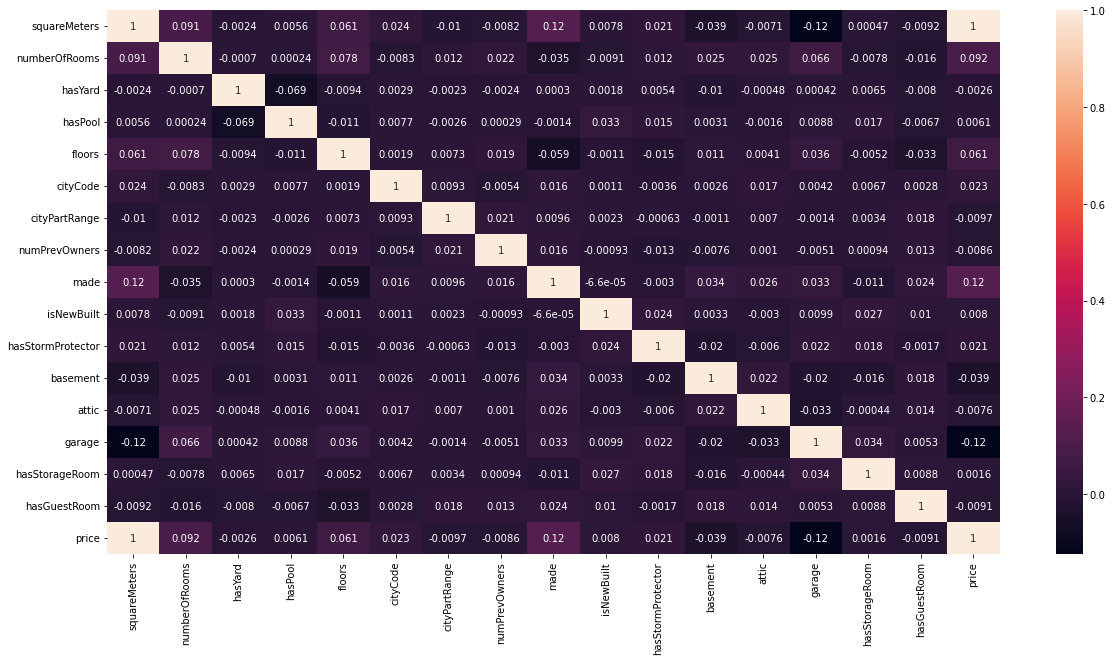

In [14]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),annot=True)

# **3.7 Plots**

In [15]:
# def plots(df, variable):
#     # define figure size
#     fig, ax = plt.subplots(1, 5, figsize=(24, 4))
    
#     # histogram
#     sns.histplot(df[variable], bins=30, kde=True, ax=ax[0])
#     ax[0].set_title('Histogram')
    
#     # KDE plot
#     sns.kdeplot(df[variable], ax=ax[1])
#     ax[1].set_title('KDE Plot')
    
#     # Q-Q plots
#     stats.probplot(df[variable], dist="norm", plot=ax[2])
#     ax[2].set_title('Q-Q Plot')
    
#     # boxplot
#     sns.boxplot(y=df[variable], ax=ax[3])
#     ax[3].set_title('Boxplot')
    
#     # scatterplot
#     sns.scatterplot(x=df.index, y=df[variable], ax=ax[4])
#     ax[4].set_title('Scatterplot')
    
#     plt.tight_layout()
#     plt.show()

# for i in train.columns:
#     plots(train ,i)

# **3.8 Defining feature and target**

In [16]:
# train.drop(index=20576 ,inplace=True)
# train.drop(index=4741 ,inplace=True)

In [17]:
X = train.drop('price' ,axis =1)
y = train['price']

# **3.9 Checking Multicollinearity**

<AxesSubplot:>

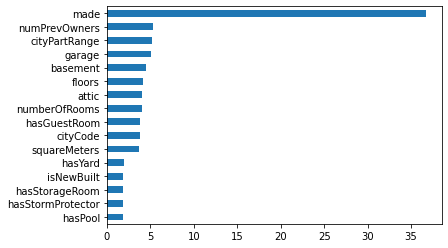

In [18]:
vif_list = []
for i in range(len(X.columns)):
    vif = variance_inflation_factor(X.to_numpy() ,i)
    vif_list.append(vif)
    
s1 = pd.Series(vif_list ,index = X.columns)
s1.sort_values().plot(kind = 'barh')

<AxesSubplot:>

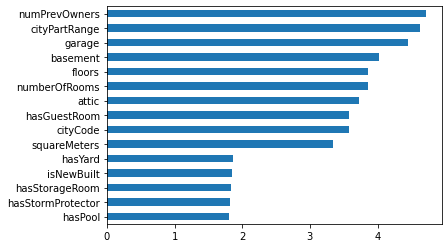

In [19]:
#dropping 'made' column from X 
X = X.drop('made' ,axis = 1)
vif_list = []
for i in range(len(X.columns)):
    vif = variance_inflation_factor(X.to_numpy() ,i)
    vif_list.append(vif)
    
s1 = pd.Series(vif_list ,index = X.columns)
s1.sort_values().plot(kind = 'barh')

# **3.10 Model Creation**

In [20]:
# regression.setup(X,target=y ,session_id=42) #UG #PS

## ***3.10.1 Comparing Models***

In [21]:
# regression.compare_models()

## ***3.10.2 GradientBoostingRegressor***

In [22]:

## Objective Fuction
def objective(trial):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    gamma_list = trial.suggest_loguniform('gamma_list' , 1e-3 ,1)
    booster_list = trial.suggest_categorical('booster_list', ['gbtree', 'gblinear'])
    max_depth = trial.suggest_int('max_depth', 3, 10)
    colsample_bytree_list = trial.suggest_loguniform('colsample_bytree_list', 1e-2,1)
    min_child_weight_list = trial.suggest_int('min_child_weight_list', 1, 8)
    subsample_list = trial.suggest_loguniform('subsample_list', 1e-2, 1)
    reg_alpha_list = trial.suggest_loguniform('reg_alpha_list' , 1e-1 ,1)
    reg_lambda_list = trial.suggest_loguniform('reg_lambda_list' , 1e-2 , 1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        gamma_list = gamma_list,
        booster_list=booster_list,
        max_depth=max_depth,
        colsample_bytree_list=colsample_bytree_list,
        min_child_weight_list=min_child_weight_list,
        subsample_list = subsample_list,
        reg_alpha_list = reg_alpha_list,
        reg_lambda_list = reg_lambda_list,
        random_state=0
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    mse = mean_squared_error(y_valid, y_pred)
    return mse


## Study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)


 ## Saving Results
best_trial = study.best_trial
best_params = best_trial.params
print('Best parameters: ', best_params)

[I 2023-03-03 08:15:55,900] A new study created in memory with name: no-name-105fb3ca-bd3a-44fd-9ff9-c9bcf66c9fdf


[08:15:55] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:05,574] Trial 0 finished with value: 24629748467.373592 and parameters: {'n_estimators': 522, 'learning_rate': 0.016755515936327327, 'gamma_list': 0.014049911709085355, 'booster_list': 'gbtree', 'max_depth': 7, 'colsample_bytree_list': 0.5676228311334539, 'min_child_weight_list': 4, 'subsample_list': 0.0748161201640917, 'reg_alpha_list': 0.37856724371842726, 'reg_lambda_list': 0.28989037961080266}. Best is trial 0 with value: 24629748467.373592.


[08:16:05] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:07,251] Trial 1 finished with value: 20369233223262.465 and parameters: {'n_estimators': 91, 'learning_rate': 0.0020622676103622616, 'gamma_list': 0.005074711394864248, 'booster_list': 'gblinear', 'max_depth': 9, 'colsample_bytree_list': 0.01276108827634283, 'min_child_weight_list': 2, 'subsample_list': 0.3153361158880616, 'reg_alpha_list': 0.29949659430939707, 'reg_lambda_list': 0.33891682295872977}. Best is trial 0 with value: 24629748467.373592.


[08:16:07] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:10,677] Trial 2 finished with value: 25626820443.40489 and parameters: {'n_estimators': 212, 'learning_rate': 0.09392336966734502, 'gamma_list': 0.2033960958434612, 'booster_list': 'gblinear', 'max_depth': 6, 'colsample_bytree_list': 0.011366006273954624, 'min_child_weight_list': 6, 'subsample_list': 0.02698186799138358, 'reg_alpha_list': 0.23496125380458321, 'reg_lambda_list': 0.012527659043191985}. Best is trial 0 with value: 24629748467.373592.


[08:16:10] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:23,309] Trial 3 finished with value: 24847140519.467228 and parameters: {'n_estimators': 740, 'learning_rate': 0.07084893962705997, 'gamma_list': 0.003674439919792061, 'booster_list': 'gbtree', 'max_depth': 6, 'colsample_bytree_list': 0.9755601243089294, 'min_child_weight_list': 3, 'subsample_list': 0.020952063180555168, 'reg_alpha_list': 0.7718615359685213, 'reg_lambda_list': 0.1137279874646079}. Best is trial 0 with value: 24629748467.373592.


[08:16:23] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:35,700] Trial 4 finished with value: 25145753638.753403 and parameters: {'n_estimators': 791, 'learning_rate': 0.00925383262618906, 'gamma_list': 0.4658984925367984, 'booster_list': 'gbtree', 'max_depth': 6, 'colsample_bytree_list': 0.09677029705221198, 'min_child_weight_list': 8, 'subsample_list': 0.612032600935359, 'reg_alpha_list': 0.1130245019986977, 'reg_lambda_list': 0.7424401346572164}. Best is trial 0 with value: 24629748467.373592.


[08:16:35] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:41,359] Trial 5 finished with value: 590745423954.3186 and parameters: {'n_estimators': 442, 'learning_rate': 0.004476201629241216, 'gamma_list': 0.003520742484379532, 'booster_list': 'gblinear', 'max_depth': 5, 'colsample_bytree_list': 0.06323173693556446, 'min_child_weight_list': 6, 'subsample_list': 0.6632063109038207, 'reg_alpha_list': 0.16442787146585763, 'reg_lambda_list': 0.06154198280919273}. Best is trial 0 with value: 24629748467.373592.


[08:16:41] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:42,419] Trial 6 finished with value: 25593322490011.496 and parameters: {'n_estimators': 63, 'learning_rate': 0.0011645631312085403, 'gamma_list': 0.15795636873038554, 'booster_list': 'gblinear', 'max_depth': 7, 'colsample_bytree_list': 0.0764692323299376, 'min_child_weight_list': 7, 'subsample_list': 0.31050590764867847, 'reg_alpha_list': 0.858487030468508, 'reg_lambda_list': 0.03708641118172945}. Best is trial 0 with value: 24629748467.373592.


[08:16:42] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:16:56,979] Trial 7 finished with value: 25526929793.420033 and parameters: {'n_estimators': 877, 'learning_rate': 0.005829892700577734, 'gamma_list': 0.001344515822362568, 'booster_list': 'gblinear', 'max_depth': 6, 'colsample_bytree_list': 0.41750736197041266, 'min_child_weight_list': 3, 'subsample_list': 0.300273478821282, 'reg_alpha_list': 0.6254258498056874, 'reg_lambda_list': 0.8988006419099789}. Best is trial 0 with value: 24629748467.373592.


[08:16:57] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:17:10,397] Trial 8 finished with value: 25114415427.312588 and parameters: {'n_estimators': 723, 'learning_rate': 0.02036131392037437, 'gamma_list': 0.008099233140752485, 'booster_list': 'gbtree', 'max_depth': 7, 'colsample_bytree_list': 0.012161890639513747, 'min_child_weight_list': 1, 'subsample_list': 0.044556293115537556, 'reg_alpha_list': 0.25906296205797613, 'reg_lambda_list': 0.013316378636370656}. Best is trial 0 with value: 24629748467.373592.


[08:17:10] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:17:17,148] Trial 9 finished with value: 26635085938.060913 and parameters: {'n_estimators': 540, 'learning_rate': 0.032581708155423, 'gamma_list': 0.0025533699814200106, 'booster_list': 'gblinear', 'max_depth': 4, 'colsample_bytree_list': 0.0706241618917865, 'min_child_weight_list': 7, 'subsample_list': 0.05323397444410895, 'reg_alpha_list': 0.2620533148475496, 'reg_lambda_list': 0.012249443388796737}. Best is trial 0 with value: 24629748467.373592.


[08:17:17] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:17:28,153] Trial 10 finished with value: 28595796257.20957 and parameters: {'n_estimators': 412, 'learning_rate': 0.020612916810338132, 'gamma_list': 0.018934484660617423, 'booster_list': 'gbtree', 'max_depth': 10, 'colsample_bytree_list': 0.3168691101779071, 'min_child_weight_list': 4, 'subsample_list': 0.10419365215788519, 'reg_alpha_list': 0.4698215011570417, 'reg_lambda_list': 0.22432371736083473}. Best is trial 0 with value: 24629748467.373592.


[08:17:28] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:17:41,361] Trial 11 finished with value: 25392290998.557827 and parameters: {'n_estimators': 613, 'learning_rate': 0.09927879288139525, 'gamma_list': 0.027095395262488536, 'booster_list': 'gbtree', 'max_depth': 8, 'colsample_bytree_list': 0.9439000458014328, 'min_child_weight_list': 4, 'subsample_list': 0.010302235718456496, 'reg_alpha_list': 0.4884473121974149, 'reg_lambda_list': 0.15420340943062452}. Best is trial 0 with value: 24629748467.373592.


[08:17:41] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:17:50,411] Trial 12 finished with value: 27251757190.113266 and parameters: {'n_estimators': 952, 'learning_rate': 0.04154020689512025, 'gamma_list': 0.010408343165597187, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.9621917458048489, 'min_child_weight_list': 3, 'subsample_list': 0.012109488163493111, 'reg_alpha_list': 0.9631166248615937, 'reg_lambda_list': 0.10089200822834604}. Best is trial 0 with value: 24629748467.373592.


[08:17:50] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:05,409] Trial 13 finished with value: 25124209198.739418 and parameters: {'n_estimators': 695, 'learning_rate': 0.049295507511623524, 'gamma_list': 0.0011331918726594473, 'booster_list': 'gbtree', 'max_depth': 8, 'colsample_bytree_list': 0.4692116107504787, 'min_child_weight_list': 5, 'subsample_list': 0.09886752934060634, 'reg_alpha_list': 0.4357735070227173, 'reg_lambda_list': 0.365193817551801}. Best is trial 0 with value: 24629748467.373592.


[08:18:05] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:10,222] Trial 14 finished with value: 24958999112.650303 and parameters: {'n_estimators': 363, 'learning_rate': 0.015887024877099098, 'gamma_list': 0.05252853703796096, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.2197890644584992, 'min_child_weight_list': 2, 'subsample_list': 0.01995085718472519, 'reg_alpha_list': 0.637998438596513, 'reg_lambda_list': 0.1203942944107661}. Best is trial 0 with value: 24629748467.373592.


[08:18:10] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:24,157] Trial 15 finished with value: 25072508737.150608 and parameters: {'n_estimators': 588, 'learning_rate': 0.057697421286186164, 'gamma_list': 0.012276208436748665, 'booster_list': 'gbtree', 'max_depth': 8, 'colsample_bytree_list': 0.6015671398520614, 'min_child_weight_list': 3, 'subsample_list': 0.020960446726984595, 'reg_alpha_list': 0.3714865373631608, 'reg_lambda_list': 0.061470396889435334}. Best is trial 0 with value: 24629748467.373592.


[08:18:24] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:28,133] Trial 16 finished with value: 24614984096.65339 and parameters: {'n_estimators': 295, 'learning_rate': 0.025029045093632154, 'gamma_list': 0.005231900285758964, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.20022739485855615, 'min_child_weight_list': 5, 'subsample_list': 0.04980070892735897, 'reg_alpha_list': 0.6694033854476413, 'reg_lambda_list': 0.28078865643878304}. Best is trial 16 with value: 24614984096.65339.


[08:18:28] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:31,042] Trial 17 finished with value: 24094378032.633057 and parameters: {'n_estimators': 273, 'learning_rate': 0.0296815985429543, 'gamma_list': 0.04996120694567543, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.17935383145984812, 'min_child_weight_list': 5, 'subsample_list': 0.082188180475345, 'reg_alpha_list': 0.5911022727905023, 'reg_lambda_list': 0.437893385482619}. Best is trial 17 with value: 24094378032.633057.


[08:18:31] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:33,219] Trial 18 finished with value: 24255734763.834373 and parameters: {'n_estimators': 256, 'learning_rate': 0.029635572193894847, 'gamma_list': 0.052902801862856015, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.19044232549528545, 'min_child_weight_list': 5, 'subsample_list': 0.14040916626916183, 'reg_alpha_list': 0.5941801460322444, 'reg_lambda_list': 0.5297349793570746}. Best is trial 17 with value: 24094378032.633057.


[08:18:33] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:35,010] Trial 19 finished with value: 24207486471.552223 and parameters: {'n_estimators': 210, 'learning_rate': 0.029871275299153427, 'gamma_list': 0.061645379991097954, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.1602699747754214, 'min_child_weight_list': 6, 'subsample_list': 0.1417260805404127, 'reg_alpha_list': 0.5514150890378501, 'reg_lambda_list': 0.5802929075858946}. Best is trial 17 with value: 24094378032.633057.


[08:18:35] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:36,371] Trial 20 finished with value: 24557471174.256264 and parameters: {'n_estimators': 124, 'learning_rate': 0.04142885684743709, 'gamma_list': 0.05033923837776569, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.12777413514546862, 'min_child_weight_list': 8, 'subsample_list': 0.16454626042103523, 'reg_alpha_list': 0.9556824068426891, 'reg_lambda_list': 0.5642391207376342}. Best is trial 17 with value: 24094378032.633057.


[08:18:36] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:38,146] Trial 21 finished with value: 24195362656.690212 and parameters: {'n_estimators': 207, 'learning_rate': 0.030017157948467207, 'gamma_list': 0.052809113828991464, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.15394051085895297, 'min_child_weight_list': 6, 'subsample_list': 0.15631411193461195, 'reg_alpha_list': 0.535668478960135, 'reg_lambda_list': 0.5576286426810092}. Best is trial 17 with value: 24094378032.633057.


[08:18:38] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:39,547] Trial 22 finished with value: 25069118902.775757 and parameters: {'n_estimators': 154, 'learning_rate': 0.03272982635539861, 'gamma_list': 0.09722535540445895, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.14554741062745932, 'min_child_weight_list': 6, 'subsample_list': 0.19400037662478586, 'reg_alpha_list': 0.5389062680969651, 'reg_lambda_list': 0.8444725524443747}. Best is trial 17 with value: 24094378032.633057.


[08:18:39] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:42,911] Trial 23 finished with value: 33376841857.25212 and parameters: {'n_estimators': 314, 'learning_rate': 0.012792013938744445, 'gamma_list': 0.029078503260701518, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.26258614538195024, 'min_child_weight_list': 7, 'subsample_list': 0.0845181753902344, 'reg_alpha_list': 0.726560401423807, 'reg_lambda_list': 0.5110351652270918}. Best is trial 17 with value: 24094378032.633057.


[08:18:42] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:44,493] Trial 24 finished with value: 25064895201.738598 and parameters: {'n_estimators': 178, 'learning_rate': 0.0637233551275029, 'gamma_list': 0.08991356026671615, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.14037635100351295, 'min_child_weight_list': 6, 'subsample_list': 0.14197035214759604, 'reg_alpha_list': 0.5801500910328117, 'reg_lambda_list': 0.9615415358518228}. Best is trial 17 with value: 24094378032.633057.


[08:18:44] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:47,312] Trial 25 finished with value: 24285059725.474903 and parameters: {'n_estimators': 258, 'learning_rate': 0.026818539091907706, 'gamma_list': 0.021142842305909404, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.3239851491342759, 'min_child_weight_list': 5, 'subsample_list': 0.0689278920470991, 'reg_alpha_list': 0.7729640307116085, 'reg_lambda_list': 0.43169116121965806}. Best is trial 17 with value: 24094378032.633057.


[08:18:47] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:51,517] Trial 26 finished with value: 25048014055.077553 and parameters: {'n_estimators': 381, 'learning_rate': 0.045108254216426974, 'gamma_list': 0.038169530738770475, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.09580221209949079, 'min_child_weight_list': 7, 'subsample_list': 0.22097120183722085, 'reg_alpha_list': 0.534402423153153, 'reg_lambda_list': 0.626148769085584}. Best is trial 17 with value: 24094378032.633057.


[08:18:51] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:53,802] Trial 27 finished with value: 247725738158.88055 and parameters: {'n_estimators': 210, 'learning_rate': 0.011611890210751279, 'gamma_list': 0.09541762017447117, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.0488263588094824, 'min_child_weight_list': 6, 'subsample_list': 0.1128524715260108, 'reg_alpha_list': 0.40103118827603274, 'reg_lambda_list': 0.2089106026459678}. Best is trial 17 with value: 24094378032.633057.


[08:18:53] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:54,540] Trial 28 finished with value: 2903378533975.764 and parameters: {'n_estimators': 50, 'learning_rate': 0.02308657774803225, 'gamma_list': 0.8138612161777075, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.16932409127111217, 'min_child_weight_list': 5, 'subsample_list': 0.12799920265611917, 'reg_alpha_list': 0.49501469810280263, 'reg_lambda_list': 0.3944371087549021}. Best is trial 17 with value: 24094378032.633057.


[08:18:54] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:18:58,508] Trial 29 finished with value: 24254077324.61673 and parameters: {'n_estimators': 473, 'learning_rate': 0.016771990549616228, 'gamma_list': 0.014809104222624048, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.25748700823655096, 'min_child_weight_list': 4, 'subsample_list': 0.07412783831739735, 'reg_alpha_list': 0.36220403146310043, 'reg_lambda_list': 0.6591470436704681}. Best is trial 17 with value: 24094378032.633057.


[08:18:58] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:01,949] Trial 30 finished with value: 25481157002.78507 and parameters: {'n_estimators': 325, 'learning_rate': 0.03523319257765366, 'gamma_list': 0.022454932384229093, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.12054805436168595, 'min_child_weight_list': 6, 'subsample_list': 0.22092490586235947, 'reg_alpha_list': 0.43188219908556635, 'reg_lambda_list': 0.2858623266778405}. Best is trial 17 with value: 24094378032.633057.


[08:19:02] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:05,939] Trial 31 finished with value: 24255858707.268208 and parameters: {'n_estimators': 471, 'learning_rate': 0.018120728336226726, 'gamma_list': 0.014019553587730991, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2294862392173396, 'min_child_weight_list': 4, 'subsample_list': 0.0994062104521196, 'reg_alpha_list': 0.37029416873808335, 'reg_lambda_list': 0.6099454633821073}. Best is trial 17 with value: 24094378032.633057.


[08:19:06] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:08,026] Trial 32 finished with value: 39844239343.543976 and parameters: {'n_estimators': 245, 'learning_rate': 0.01546220722424801, 'gamma_list': 0.03626578581873037, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.1715696978688343, 'min_child_weight_list': 4, 'subsample_list': 0.056941896524351686, 'reg_alpha_list': 0.3364259453910295, 'reg_lambda_list': 0.9967287783713741}. Best is trial 17 with value: 24094378032.633057.


[08:19:08] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:13,371] Trial 33 finished with value: 25750278731.456383 and parameters: {'n_estimators': 495, 'learning_rate': 0.025254233955151827, 'gamma_list': 0.018948416069469523, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.32477503640060945, 'min_child_weight_list': 5, 'subsample_list': 0.07442908484654275, 'reg_alpha_list': 0.5267035850896834, 'reg_lambda_list': 0.7043932523615879}. Best is trial 17 with value: 24094378032.633057.


[08:19:13] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:14,768] Trial 34 finished with value: 24735041267.128048 and parameters: {'n_estimators': 123, 'learning_rate': 0.07640793559469962, 'gamma_list': 0.064802446571417, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.27427950791156275, 'min_child_weight_list': 4, 'subsample_list': 0.0767184463471936, 'reg_alpha_list': 0.4505784897644783, 'reg_lambda_list': 0.41965162821556484}. Best is trial 17 with value: 24094378032.633057.


[08:19:14] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:16,758] Trial 35 finished with value: 24784199624.909325 and parameters: {'n_estimators': 213, 'learning_rate': 0.050945771776728106, 'gamma_list': 0.1471511064497575, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.11204666388678652, 'min_child_weight_list': 7, 'subsample_list': 0.04046390119386018, 'reg_alpha_list': 0.3216179044837082, 'reg_lambda_list': 0.718359062539943}. Best is trial 17 with value: 24094378032.633057.


[08:19:16] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:22,695] Trial 36 finished with value: 26117534616.61733 and parameters: {'n_estimators': 369, 'learning_rate': 0.03469402336669792, 'gamma_list': 0.03595009917930274, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.1769717395684909, 'min_child_weight_list': 6, 'subsample_list': 0.16440186516956706, 'reg_alpha_list': 0.7032909827303357, 'reg_lambda_list': 0.45569074167932355}. Best is trial 17 with value: 24094378032.633057.


[08:19:22] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:24,591] Trial 37 finished with value: 1445459977723.186 and parameters: {'n_estimators': 172, 'learning_rate': 0.008819115207683637, 'gamma_list': 0.291671784725424, 'booster_list': 'gblinear', 'max_depth': 4, 'colsample_bytree_list': 0.0908236996329898, 'min_child_weight_list': 2, 'subsample_list': 0.41854000308271105, 'reg_alpha_list': 0.5465522060827073, 'reg_lambda_list': 0.33324446920751993}. Best is trial 17 with value: 24094378032.633057.


[08:19:24] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:29,272] Trial 38 finished with value: 24210791839.232098 and parameters: {'n_estimators': 543, 'learning_rate': 0.015826657194681855, 'gamma_list': 0.07052484093036482, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.050303624803606874, 'min_child_weight_list': 6, 'subsample_list': 0.11678400548754693, 'reg_alpha_list': 0.40373127628840655, 'reg_lambda_list': 0.7273305355718015}. Best is trial 17 with value: 24094378032.633057.


[08:19:29] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:39,424] Trial 39 finished with value: 25246405641.934574 and parameters: {'n_estimators': 641, 'learning_rate': 0.02371821034508548, 'gamma_list': 0.07943861972459308, 'booster_list': 'gblinear', 'max_depth': 6, 'colsample_bytree_list': 0.048430350918723636, 'min_child_weight_list': 8, 'subsample_list': 0.24466941004008652, 'reg_alpha_list': 0.6356458959695069, 'reg_lambda_list': 0.4853065663163775}. Best is trial 17 with value: 24094378032.633057.


[08:19:39] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:46,822] Trial 40 finished with value: 27831439827.65097 and parameters: {'n_estimators': 565, 'learning_rate': 0.07433915485027608, 'gamma_list': 0.20455073485447647, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.02853999428098893, 'min_child_weight_list': 7, 'subsample_list': 0.1150436862788587, 'reg_alpha_list': 0.41340977915920935, 'reg_lambda_list': 0.8378006058584356}. Best is trial 17 with value: 24094378032.633057.


[08:19:46] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:19:50,776] Trial 41 finished with value: 24307674155.89286 and parameters: {'n_estimators': 457, 'learning_rate': 0.018332025137067488, 'gamma_list': 0.04386926152417762, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.16024135883657484, 'min_child_weight_list': 5, 'subsample_list': 0.0864152089580651, 'reg_alpha_list': 0.3591342473011146, 'reg_lambda_list': 0.6672026243654968}. Best is trial 17 with value: 24094378032.633057.


[08:19:50] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:00,208] Trial 42 finished with value: 25413834363.30114 and parameters: {'n_estimators': 789, 'learning_rate': 0.014076049434270448, 'gamma_list': 0.07387203997892024, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.10832197944057625, 'min_child_weight_list': 6, 'subsample_list': 0.1626610126194288, 'reg_alpha_list': 0.30901410007913555, 'reg_lambda_list': 0.7338669020699335}. Best is trial 17 with value: 24094378032.633057.


[08:20:00] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:03,724] Trial 43 finished with value: 24123261874.21636 and parameters: {'n_estimators': 409, 'learning_rate': 0.02035701416092548, 'gamma_list': 0.12449155365632905, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.22808863100951884, 'min_child_weight_list': 6, 'subsample_list': 0.06124645341241118, 'reg_alpha_list': 0.47533218001807936, 'reg_lambda_list': 0.5468893543418504}. Best is trial 17 with value: 24094378032.633057.


[08:20:03] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:08,107] Trial 44 finished with value: 24305751197.64334 and parameters: {'n_estimators': 412, 'learning_rate': 0.020450496823020397, 'gamma_list': 0.11251584459148758, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.13970735274802284, 'min_child_weight_list': 6, 'subsample_list': 0.1216579771843582, 'reg_alpha_list': 0.48039600110243547, 'reg_lambda_list': 0.5206920859869492}. Best is trial 17 with value: 24094378032.633057.


[08:20:08] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:12,647] Trial 45 finished with value: 25065324155.727448 and parameters: {'n_estimators': 524, 'learning_rate': 0.027607234472262935, 'gamma_list': 0.06076427841832319, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.21076695565221762, 'min_child_weight_list': 7, 'subsample_list': 0.037053035691822875, 'reg_alpha_list': 0.6023292422393055, 'reg_lambda_list': 0.330897961287783}. Best is trial 17 with value: 24094378032.633057.


[08:20:12] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:15,199] Trial 46 finished with value: 24976851013.40652 and parameters: {'n_estimators': 293, 'learning_rate': 0.038040677674626044, 'gamma_list': 0.06738376055506917, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.07940245879819469, 'min_child_weight_list': 6, 'subsample_list': 0.06242667044345699, 'reg_alpha_list': 0.40759586443171886, 'reg_lambda_list': 0.7923909852975235}. Best is trial 17 with value: 24094378032.633057.


[08:20:15] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:16,364] Trial 47 finished with value: 3668264329652.5625 and parameters: {'n_estimators': 101, 'learning_rate': 0.010349446230584838, 'gamma_list': 0.1339774974855174, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.12253948660295758, 'min_child_weight_list': 6, 'subsample_list': 0.08875091996909693, 'reg_alpha_list': 0.482932384186999, 'reg_lambda_list': 0.4059674071941146}. Best is trial 17 with value: 24094378032.633057.


[08:20:16] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:19,981] Trial 48 finished with value: 24506118340.887966 and parameters: {'n_estimators': 427, 'learning_rate': 0.021651763417253354, 'gamma_list': 0.17665954213427595, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.0908006605800469, 'min_child_weight_list': 5, 'subsample_list': 0.061898750547888015, 'reg_alpha_list': 0.821740783908899, 'reg_lambda_list': 0.5664708885503339}. Best is trial 17 with value: 24094378032.633057.


[08:20:20] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:30,569] Trial 49 finished with value: 28921696544.882164 and parameters: {'n_estimators': 339, 'learning_rate': 0.030035333736994255, 'gamma_list': 0.11776883200350739, 'booster_list': 'gbtree', 'max_depth': 10, 'colsample_bytree_list': 0.14857734539414083, 'min_child_weight_list': 7, 'subsample_list': 0.10332430492909388, 'reg_alpha_list': 0.6758529132913386, 'reg_lambda_list': 0.9897853682257279}. Best is trial 17 with value: 24094378032.633057.


[08:20:30] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:39,150] Trial 50 finished with value: 26310697235.7898 and parameters: {'n_estimators': 656, 'learning_rate': 0.03844061090230674, 'gamma_list': 0.046634002776118004, 'booster_list': 'gblinear', 'max_depth': 5, 'colsample_bytree_list': 0.19677282229595888, 'min_child_weight_list': 5, 'subsample_list': 0.048976419628777836, 'reg_alpha_list': 0.4568347985702148, 'reg_lambda_list': 0.244281613451354}. Best is trial 17 with value: 24094378032.633057.


[08:20:39] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:43,310] Trial 51 finished with value: 24194863103.15249 and parameters: {'n_estimators': 484, 'learning_rate': 0.01739672798153925, 'gamma_list': 0.03147806813291422, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2570755431123117, 'min_child_weight_list': 6, 'subsample_list': 0.07305480169033444, 'reg_alpha_list': 0.28139829269416916, 'reg_lambda_list': 0.6361413691553467}. Best is trial 17 with value: 24094378032.633057.


[08:20:43] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:47,695] Trial 52 finished with value: 24433584189.917503 and parameters: {'n_estimators': 505, 'learning_rate': 0.019183485931021503, 'gamma_list': 0.030957654949226112, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.41052909198798365, 'min_child_weight_list': 6, 'subsample_list': 0.09364137407142087, 'reg_alpha_list': 0.2716770854173194, 'reg_lambda_list': 0.3593813243664091}. Best is trial 17 with value: 24094378032.633057.


[08:20:47] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:51,016] Trial 53 finished with value: 24351495098.55532 and parameters: {'n_estimators': 389, 'learning_rate': 0.01495113965877973, 'gamma_list': 0.057219462162339176, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.23056111121537368, 'min_child_weight_list': 6, 'subsample_list': 0.13606742812713388, 'reg_alpha_list': 0.5855752009923353, 'reg_lambda_list': 0.5902234316463163}. Best is trial 17 with value: 24094378032.633057.


[08:20:51] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:20:58,113] Trial 54 finished with value: 26388905468.034565 and parameters: {'n_estimators': 570, 'learning_rate': 0.02928303043899933, 'gamma_list': 0.0862625410745949, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.18223428947332834, 'min_child_weight_list': 6, 'subsample_list': 0.0722045039141941, 'reg_alpha_list': 0.21379777250753867, 'reg_lambda_list': 0.4698280891866265}. Best is trial 17 with value: 24094378032.633057.


[08:20:58] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:03,953] Trial 55 finished with value: 28741346363.501827 and parameters: {'n_estimators': 274, 'learning_rate': 0.021550660619888126, 'gamma_list': 0.026798825590869244, 'booster_list': 'gbtree', 'max_depth': 9, 'colsample_bytree_list': 0.2837793711433775, 'min_child_weight_list': 7, 'subsample_list': 0.05618080393394646, 'reg_alpha_list': 0.5087278502249928, 'reg_lambda_list': 0.8079919379533702}. Best is trial 17 with value: 24094378032.633057.


[08:21:04] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:05,936] Trial 56 finished with value: 113202891376.84938 and parameters: {'n_estimators': 223, 'learning_rate': 0.013076474159258326, 'gamma_list': 0.04302217310466878, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.15219498804808576, 'min_child_weight_list': 5, 'subsample_list': 0.11352495386856296, 'reg_alpha_list': 0.4424768626193035, 'reg_lambda_list': 0.5764321437869085}. Best is trial 17 with value: 24094378032.633057.


[08:21:06] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:09,673] Trial 57 finished with value: 27016034626.124386 and parameters: {'n_estimators': 351, 'learning_rate': 0.04564400724083557, 'gamma_list': 0.06227629021471025, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.3554718873395677, 'min_child_weight_list': 8, 'subsample_list': 0.08722082349539634, 'reg_alpha_list': 0.5549600138290816, 'reg_lambda_list': 0.4668709615186892}. Best is trial 17 with value: 24094378032.633057.


[08:21:09] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:14,305] Trial 58 finished with value: 25406519861.184002 and parameters: {'n_estimators': 540, 'learning_rate': 0.032213009503797956, 'gamma_list': 0.09909797242963408, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.23893625584165265, 'min_child_weight_list': 7, 'subsample_list': 0.1526680835065278, 'reg_alpha_list': 0.40540336055716114, 'reg_lambda_list': 0.7835326742800539}. Best is trial 17 with value: 24094378032.633057.


[08:21:14] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:16,908] Trial 59 finished with value: 46334106109.37004 and parameters: {'n_estimators': 145, 'learning_rate': 0.024529781075567723, 'gamma_list': 0.026266671733445445, 'booster_list': 'gbtree', 'max_depth': 7, 'colsample_bytree_list': 0.2036313157165856, 'min_child_weight_list': 5, 'subsample_list': 0.1865063289926942, 'reg_alpha_list': 0.6448014616921408, 'reg_lambda_list': 0.3572078008001967}. Best is trial 17 with value: 24094378032.633057.


[08:21:17] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:22,133] Trial 60 finished with value: 24578683516.12678 and parameters: {'n_estimators': 624, 'learning_rate': 0.01637827315450799, 'gamma_list': 0.04679697341825739, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.29794078222549963, 'min_child_weight_list': 6, 'subsample_list': 0.12543907302159898, 'reg_alpha_list': 0.4999875132238277, 'reg_lambda_list': 0.8712339151894952}. Best is trial 17 with value: 24094378032.633057.


[08:21:22] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:27,060] Trial 61 finished with value: 24019666745.614834 and parameters: {'n_estimators': 460, 'learning_rate': 0.018545480722399716, 'gamma_list': 0.015515426032396888, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.25428266014516565, 'min_child_weight_list': 3, 'subsample_list': 0.06584345329692001, 'reg_alpha_list': 0.35818828822732274, 'reg_lambda_list': 0.6611174211533184}. Best is trial 61 with value: 24019666745.614834.


[08:21:27] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:32,061] Trial 62 finished with value: 24665634422.429283 and parameters: {'n_estimators': 592, 'learning_rate': 0.018425125697556156, 'gamma_list': 0.039807014159515694, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2246177468099067, 'min_child_weight_list': 3, 'subsample_list': 0.06621515309605461, 'reg_alpha_list': 0.38516193452496333, 'reg_lambda_list': 0.6643899987452214}. Best is trial 61 with value: 24019666745.614834.


[08:21:32] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:36,670] Trial 63 finished with value: 25913519624.70128 and parameters: {'n_estimators': 444, 'learning_rate': 0.027314151487953985, 'gamma_list': 0.07513961690637332, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.25935132107664344, 'min_child_weight_list': 1, 'subsample_list': 0.08129480136075556, 'reg_alpha_list': 0.28856916000776595, 'reg_lambda_list': 0.49717241534875334}. Best is trial 61 with value: 24019666745.614834.


[08:21:36] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:38,394] Trial 64 finished with value: 344575468553.5275 and parameters: {'n_estimators': 194, 'learning_rate': 0.011701886601372766, 'gamma_list': 0.03322478044297695, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.1331273572779673, 'min_child_weight_list': 3, 'subsample_list': 0.10118770351640037, 'reg_alpha_list': 0.34265537118645323, 'reg_lambda_list': 0.5380946035828773}. Best is trial 61 with value: 24019666745.614834.


[08:21:38] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:42,824] Trial 65 finished with value: 24329935834.40964 and parameters: {'n_estimators': 400, 'learning_rate': 0.022010846268291657, 'gamma_list': 0.016790384080862596, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.16286263201033976, 'min_child_weight_list': 2, 'subsample_list': 0.1385176635775334, 'reg_alpha_list': 0.5683396990356014, 'reg_lambda_list': 0.656255925253742}. Best is trial 61 with value: 24019666745.614834.


[08:21:42] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:45,483] Trial 66 finished with value: 24964599722.191353 and parameters: {'n_estimators': 304, 'learning_rate': 0.01685259966174492, 'gamma_list': 0.009022646968873461, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.36907413374651354, 'min_child_weight_list': 5, 'subsample_list': 0.046058432315948104, 'reg_alpha_list': 0.4618017417329865, 'reg_lambda_list': 0.4002829028909168}. Best is trial 61 with value: 24019666745.614834.


[08:21:45] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:21:49,572] Trial 67 finished with value: 25244219384.53202 and parameters: {'n_estimators': 482, 'learning_rate': 0.03388322275169971, 'gamma_list': 0.05262818843885207, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.19388957080782, 'min_child_weight_list': 6, 'subsample_list': 0.05410570159527414, 'reg_alpha_list': 0.612582082567325, 'reg_lambda_list': 0.8987230394408822}. Best is trial 61 with value: 24019666745.614834.


[08:21:49] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:00,942] Trial 68 finished with value: 29043082650.587105 and parameters: {'n_estimators': 986, 'learning_rate': 0.024935370972804283, 'gamma_list': 0.024946671815572762, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.29230566245216055, 'min_child_weight_list': 4, 'subsample_list': 0.06909699218625569, 'reg_alpha_list': 0.4263068387732902, 'reg_lambda_list': 0.5996811769265751}. Best is trial 61 with value: 24019666745.614834.


[08:22:01] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:03,127] Trial 69 finished with value: 25499375892.57904 and parameters: {'n_estimators': 246, 'learning_rate': 0.01999375580358723, 'gamma_list': 0.021519788956167994, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.2402613471748988, 'min_child_weight_list': 6, 'subsample_list': 0.09863862933590728, 'reg_alpha_list': 0.38723672889117944, 'reg_lambda_list': 0.7667410270995579}. Best is trial 61 with value: 24019666745.614834.


[08:22:03] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:14,207] Trial 70 finished with value: 24911443419.183216 and parameters: {'n_estimators': 689, 'learning_rate': 0.014533594494116474, 'gamma_list': 0.03212792882108453, 'booster_list': 'gbtree', 'max_depth': 6, 'colsample_bytree_list': 0.4706729405188297, 'min_child_weight_list': 1, 'subsample_list': 0.11352592761689925, 'reg_alpha_list': 0.5115734885417222, 'reg_lambda_list': 0.3070497078325312}. Best is trial 61 with value: 24019666745.614834.


[08:22:14] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:18,110] Trial 71 finished with value: 24086088347.127476 and parameters: {'n_estimators': 462, 'learning_rate': 0.01596017630318808, 'gamma_list': 0.015797178576471223, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.26306769534502356, 'min_child_weight_list': 4, 'subsample_list': 0.08107245345750505, 'reg_alpha_list': 0.35958649156918576, 'reg_lambda_list': 0.7072987288450778}. Best is trial 61 with value: 24019666745.614834.


[08:22:18] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:22,739] Trial 72 finished with value: 24433302722.908012 and parameters: {'n_estimators': 544, 'learning_rate': 0.01688523192514694, 'gamma_list': 0.018609757797859592, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.17785423549761936, 'min_child_weight_list': 3, 'subsample_list': 0.07771991423117712, 'reg_alpha_list': 0.3416743323519154, 'reg_lambda_list': 0.7055716991285417}. Best is trial 61 with value: 24019666745.614834.


[08:22:22] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:26,608] Trial 73 finished with value: 25048049831.42486 and parameters: {'n_estimators': 447, 'learning_rate': 0.02784745070222294, 'gamma_list': 0.011713886681725775, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2590215167170516, 'min_child_weight_list': 4, 'subsample_list': 0.059946431748724736, 'reg_alpha_list': 0.29721127720492135, 'reg_lambda_list': 0.5193648668892644}. Best is trial 61 with value: 24019666745.614834.


[08:22:26] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:32,949] Trial 74 finished with value: 24942101994.48566 and parameters: {'n_estimators': 508, 'learning_rate': 0.022294561294523906, 'gamma_list': 0.01525121742405466, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.2009081672683869, 'min_child_weight_list': 5, 'subsample_list': 0.08710803084845192, 'reg_alpha_list': 0.4342296118377307, 'reg_lambda_list': 0.42166925216874174}. Best is trial 61 with value: 24019666745.614834.


[08:22:33] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:36,480] Trial 75 finished with value: 24050821383.66542 and parameters: {'n_estimators': 417, 'learning_rate': 0.019578073326072292, 'gamma_list': 0.040094178444922884, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.13316770802761066, 'min_child_weight_list': 4, 'subsample_list': 0.0686390749670047, 'reg_alpha_list': 0.37105895299891684, 'reg_lambda_list': 0.8982490757206802}. Best is trial 61 with value: 24019666745.614834.


[08:22:36] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:40,059] Trial 76 finished with value: 24887522149.232933 and parameters: {'n_estimators': 422, 'learning_rate': 0.030284873832798286, 'gamma_list': 0.03754002375822326, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.1562349464121211, 'min_child_weight_list': 4, 'subsample_list': 0.06569270349484727, 'reg_alpha_list': 0.3727945593983494, 'reg_lambda_list': 0.9978316682606408}. Best is trial 61 with value: 24019666745.614834.


[08:22:40] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:43,101] Trial 77 finished with value: 24281544193.491356 and parameters: {'n_estimators': 277, 'learning_rate': 0.024514951581696743, 'gamma_list': 0.02955892813297238, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.1246891920348623, 'min_child_weight_list': 2, 'subsample_list': 0.07821324200711013, 'reg_alpha_list': 0.31242822344058074, 'reg_lambda_list': 0.843352182334321}. Best is trial 61 with value: 24019666745.614834.


[08:22:43] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:46,393] Trial 78 finished with value: 24089125633.08282 and parameters: {'n_estimators': 369, 'learning_rate': 0.01924086915425333, 'gamma_list': 0.022725259403468517, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3274201662371792, 'min_child_weight_list': 3, 'subsample_list': 0.04050968619149108, 'reg_alpha_list': 0.32546776668897065, 'reg_lambda_list': 0.606437209146958}. Best is trial 61 with value: 24019666745.614834.


[08:22:46] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:49,568] Trial 79 finished with value: 24105849970.15129 and parameters: {'n_estimators': 372, 'learning_rate': 0.019038604591299142, 'gamma_list': 0.013349994398103308, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.332567687228568, 'min_child_weight_list': 3, 'subsample_list': 0.0397480565885403, 'reg_alpha_list': 0.3307948717848566, 'reg_lambda_list': 0.642657442398416}. Best is trial 61 with value: 24019666745.614834.


[08:22:49] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:52,756] Trial 80 finished with value: 25624928001.588337 and parameters: {'n_estimators': 367, 'learning_rate': 0.01342945547058494, 'gamma_list': 0.01272309267461931, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.30826438979192516, 'min_child_weight_list': 3, 'subsample_list': 0.03453009656759752, 'reg_alpha_list': 0.35130298353777006, 'reg_lambda_list': 0.6298147467076283}. Best is trial 61 with value: 24019666745.614834.


[08:22:52] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:22:55,564] Trial 81 finished with value: 24286414717.50979 and parameters: {'n_estimators': 323, 'learning_rate': 0.018961318726874322, 'gamma_list': 0.017455824614288965, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3221245833335835, 'min_child_weight_list': 3, 'subsample_list': 0.04436286906914891, 'reg_alpha_list': 0.2828199845075123, 'reg_lambda_list': 0.9018818154653276}. Best is trial 61 with value: 24019666745.614834.


[08:22:55] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:00,451] Trial 82 finished with value: 24475418321.110863 and parameters: {'n_estimators': 462, 'learning_rate': 0.019650974872301517, 'gamma_list': 0.02246278293095284, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2601127896587609, 'min_child_weight_list': 3, 'subsample_list': 0.050630169973863104, 'reg_alpha_list': 0.31600784018564754, 'reg_lambda_list': 0.5456523342519788}. Best is trial 61 with value: 24019666745.614834.


[08:23:00] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:03,873] Trial 83 finished with value: 24067742905.905487 and parameters: {'n_estimators': 396, 'learning_rate': 0.017449159716949752, 'gamma_list': 0.010441464620560661, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.38427439644783606, 'min_child_weight_list': 3, 'subsample_list': 0.055875035657207694, 'reg_alpha_list': 0.3245140113574708, 'reg_lambda_list': 0.6984493940972042}. Best is trial 61 with value: 24019666745.614834.


[08:23:03] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:08,023] Trial 84 finished with value: 24807160988.528618 and parameters: {'n_estimators': 388, 'learning_rate': 0.014237237474095898, 'gamma_list': 0.00783884438690221, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.37169125454769314, 'min_child_weight_list': 3, 'subsample_list': 0.057416843283333296, 'reg_alpha_list': 0.3236536168398436, 'reg_lambda_list': 0.7502913784716273}. Best is trial 61 with value: 24019666745.614834.


[08:23:08] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:11,019] Trial 85 finished with value: 24269898107.15691 and parameters: {'n_estimators': 343, 'learning_rate': 0.01725266544803306, 'gamma_list': 0.010771499836197738, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.49767586371157063, 'min_child_weight_list': 2, 'subsample_list': 0.04368288975718907, 'reg_alpha_list': 0.32665584339119497, 'reg_lambda_list': 0.7058088888751524}. Best is trial 61 with value: 24019666745.614834.


[08:23:11] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:14,651] Trial 86 finished with value: 25069745548.055737 and parameters: {'n_estimators': 420, 'learning_rate': 0.01212846870798788, 'gamma_list': 0.014487707386570178, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.42376412637641503, 'min_child_weight_list': 4, 'subsample_list': 0.05035667609784431, 'reg_alpha_list': 0.25331107798341707, 'reg_lambda_list': 0.6306194885171655}. Best is trial 61 with value: 24019666745.614834.


[08:23:14] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:18,914] Trial 87 finished with value: 24131880513.11066 and parameters: {'n_estimators': 494, 'learning_rate': 0.015479612243569106, 'gamma_list': 0.02066064921879625, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.34362048253758226, 'min_child_weight_list': 4, 'subsample_list': 0.03324872663322786, 'reg_alpha_list': 0.3564862298742268, 'reg_lambda_list': 0.4666349556567715}. Best is trial 61 with value: 24019666745.614834.


[08:23:19] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:22,671] Trial 88 finished with value: 24473639612.848095 and parameters: {'n_estimators': 437, 'learning_rate': 0.02178831060857556, 'gamma_list': 0.020058694232866825, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.33517067146836194, 'min_child_weight_list': 4, 'subsample_list': 0.03921794905439861, 'reg_alpha_list': 0.361857634960362, 'reg_lambda_list': 0.45439024468192446}. Best is trial 61 with value: 24019666745.614834.


[08:23:22] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:27,050] Trial 89 finished with value: 24622518979.383736 and parameters: {'n_estimators': 409, 'learning_rate': 0.014808782635080842, 'gamma_list': 0.013128123113716087, 'booster_list': 'gblinear', 'max_depth': 4, 'colsample_bytree_list': 0.5893557822641359, 'min_child_weight_list': 4, 'subsample_list': 0.03216138841414638, 'reg_alpha_list': 0.3389418267619011, 'reg_lambda_list': 0.5027101375124069}. Best is trial 61 with value: 24019666745.614834.


[08:23:27] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:34,996] Trial 90 finished with value: 44602362643.01072 and parameters: {'n_estimators': 373, 'learning_rate': 0.00969277147825265, 'gamma_list': 0.01589972636832142, 'booster_list': 'gblinear', 'max_depth': 8, 'colsample_bytree_list': 0.28961187239782143, 'min_child_weight_list': 3, 'subsample_list': 0.02612134049008205, 'reg_alpha_list': 0.37524588683423893, 'reg_lambda_list': 0.9006433369719655}. Best is trial 61 with value: 24019666745.614834.


[08:23:35] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:39,019] Trial 91 finished with value: 24022940860.420437 and parameters: {'n_estimators': 482, 'learning_rate': 0.01724327297595115, 'gamma_list': 0.023700633609380257, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.3966138038346997, 'min_child_weight_list': 3, 'subsample_list': 0.06132125240782752, 'reg_alpha_list': 0.29954877770587024, 'reg_lambda_list': 0.6319452680908424}. Best is trial 61 with value: 24019666745.614834.


[08:23:39] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:43,384] Trial 92 finished with value: 24159187486.20033 and parameters: {'n_estimators': 506, 'learning_rate': 0.015701491786831775, 'gamma_list': 0.024343791419080777, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.3893435640423534, 'min_child_weight_list': 3, 'subsample_list': 0.054501087451271406, 'reg_alpha_list': 0.3554593990822132, 'reg_lambda_list': 0.3798644781882619}. Best is trial 61 with value: 24019666745.614834.


[08:23:43] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:47,255] Trial 93 finished with value: 24441556279.046238 and parameters: {'n_estimators': 453, 'learning_rate': 0.020455492416467925, 'gamma_list': 0.01899512499193548, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.3360507142588945, 'min_child_weight_list': 3, 'subsample_list': 0.06099341952184798, 'reg_alpha_list': 0.29927647983078254, 'reg_lambda_list': 0.4381791895101105}. Best is trial 61 with value: 24019666745.614834.


[08:23:47] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:51,415] Trial 94 finished with value: 24223256865.043827 and parameters: {'n_estimators': 476, 'learning_rate': 0.012608500870857615, 'gamma_list': 0.016918654259879276, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.41696834000388217, 'min_child_weight_list': 2, 'subsample_list': 0.04594928722663349, 'reg_alpha_list': 0.39463377259255294, 'reg_lambda_list': 0.7965545512177394}. Best is trial 61 with value: 24019666745.614834.


[08:23:51] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:55,683] Trial 95 finished with value: 28685811682.235935 and parameters: {'n_estimators': 400, 'learning_rate': 0.010881112496215348, 'gamma_list': 0.021816506185084523, 'booster_list': 'gblinear', 'max_depth': 4, 'colsample_bytree_list': 0.5291295363145069, 'min_child_weight_list': 4, 'subsample_list': 0.06514073755770144, 'reg_alpha_list': 0.3288899106990356, 'reg_lambda_list': 0.5757025434775095}. Best is trial 61 with value: 24019666745.614834.


[08:23:55] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:23:58,508] Trial 96 finished with value: 24124336805.58288 and parameters: {'n_estimators': 335, 'learning_rate': 0.023277146305617412, 'gamma_list': 0.010869475424002338, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.44128573923992415, 'min_child_weight_list': 3, 'subsample_list': 0.040991880475144994, 'reg_alpha_list': 0.30590753866045434, 'reg_lambda_list': 0.6744273251567293}. Best is trial 61 with value: 24019666745.614834.


[08:23:58] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:01,312] Trial 97 finished with value: 24200609119.628036 and parameters: {'n_estimators': 331, 'learning_rate': 0.024167109839975425, 'gamma_list': 0.00873787102966284, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.4294294264918996, 'min_child_weight_list': 3, 'subsample_list': 0.04129419582299237, 'reg_alpha_list': 0.3062630033132642, 'reg_lambda_list': 0.7189807817640866}. Best is trial 61 with value: 24019666745.614834.


[08:24:01] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:05,390] Trial 98 finished with value: 24036868824.794453 and parameters: {'n_estimators': 362, 'learning_rate': 0.01885396963657622, 'gamma_list': 0.010093757013482854, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.21597467107474638, 'min_child_weight_list': 3, 'subsample_list': 0.05041451476647475, 'reg_alpha_list': 0.29725132047885205, 'reg_lambda_list': 0.6715039470130917}. Best is trial 61 with value: 24019666745.614834.


[08:24:05] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:09,456] Trial 99 finished with value: 24686797998.06321 and parameters: {'n_estimators': 379, 'learning_rate': 0.018168944392456195, 'gamma_list': 0.006002517808620114, 'booster_list': 'gblinear', 'max_depth': 4, 'colsample_bytree_list': 0.22883807994153213, 'min_child_weight_list': 2, 'subsample_list': 0.05086084669124511, 'reg_alpha_list': 0.3322308312378512, 'reg_lambda_list': 0.8120494621165586}. Best is trial 61 with value: 24019666745.614834.


[08:24:09] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:13,272] Trial 100 finished with value: 24769497855.818684 and parameters: {'n_estimators': 429, 'learning_rate': 0.02658412913453832, 'gamma_list': 0.012658533027473218, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.20817278406137055, 'min_child_weight_list': 3, 'subsample_list': 0.06785222274061647, 'reg_alpha_list': 0.2651290533568136, 'reg_lambda_list': 0.6011555390401375}. Best is trial 61 with value: 24019666745.614834.


[08:24:13] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:16,328] Trial 101 finished with value: 24227269989.712948 and parameters: {'n_estimators': 352, 'learning_rate': 0.022928630610732362, 'gamma_list': 0.011044872160298053, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.28633829616822737, 'min_child_weight_list': 3, 'subsample_list': 0.057783417290053485, 'reg_alpha_list': 0.2971455323067374, 'reg_lambda_list': 0.666843990962917}. Best is trial 61 with value: 24019666745.614834.


[08:24:16] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:18,993] Trial 102 finished with value: 24175078555.957073 and parameters: {'n_estimators': 308, 'learning_rate': 0.020648182029833675, 'gamma_list': 0.014065621415941044, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.3863198041885534, 'min_child_weight_list': 3, 'subsample_list': 0.047847879887984494, 'reg_alpha_list': 0.31360179021696233, 'reg_lambda_list': 0.5228601335155822}. Best is trial 61 with value: 24019666745.614834.


[08:24:19] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:21,322] Trial 103 finished with value: 25907040083.351295 and parameters: {'n_estimators': 267, 'learning_rate': 0.018088463253436163, 'gamma_list': 0.009764532431608136, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.31388400237448044, 'min_child_weight_list': 3, 'subsample_list': 0.04169256926008872, 'reg_alpha_list': 0.3857558878137786, 'reg_lambda_list': 0.7514449800245665}. Best is trial 61 with value: 24019666745.614834.


[08:24:21] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:24,493] Trial 104 finished with value: 24332572278.826454 and parameters: {'n_estimators': 358, 'learning_rate': 0.026235147559261478, 'gamma_list': 0.010121592273553958, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.4550443070439415, 'min_child_weight_list': 2, 'subsample_list': 0.05487699771421932, 'reg_alpha_list': 0.3437698511877465, 'reg_lambda_list': 0.9134510918321248}. Best is trial 61 with value: 24019666745.614834.


[08:24:24] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:27,831] Trial 105 finished with value: 24212474951.76085 and parameters: {'n_estimators': 396, 'learning_rate': 0.01940930707879751, 'gamma_list': 0.007065521536663829, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.36092894581076407, 'min_child_weight_list': 3, 'subsample_list': 0.07133987365049553, 'reg_alpha_list': 0.2765255952540585, 'reg_lambda_list': 0.6709872636903015}. Best is trial 61 with value: 24019666745.614834.


[08:24:27] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:31,336] Trial 106 finished with value: 26710632994.918404 and parameters: {'n_estimators': 333, 'learning_rate': 0.013702434396934924, 'gamma_list': 0.015096038428383456, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.18403126295705857, 'min_child_weight_list': 4, 'subsample_list': 0.038281619379444076, 'reg_alpha_list': 0.4200857056867372, 'reg_lambda_list': 0.8580553487226505}. Best is trial 61 with value: 24019666745.614834.


[08:24:31] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:34,797] Trial 107 finished with value: 24207163216.141193 and parameters: {'n_estimators': 294, 'learning_rate': 0.02296873192579073, 'gamma_list': 0.011771225450935334, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.23972923434840296, 'min_child_weight_list': 3, 'subsample_list': 0.060916417633749186, 'reg_alpha_list': 0.2893640400401289, 'reg_lambda_list': 0.5745959860916512}. Best is trial 61 with value: 24019666745.614834.


[08:24:34] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:36,878] Trial 108 finished with value: 39327721535.269806 and parameters: {'n_estimators': 233, 'learning_rate': 0.016331735824088586, 'gamma_list': 0.025608191225108694, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.28052710708385764, 'min_child_weight_list': 2, 'subsample_list': 0.04802347204125408, 'reg_alpha_list': 0.3760765300264441, 'reg_lambda_list': 0.6173018898720568}. Best is trial 61 with value: 24019666745.614834.


[08:24:36] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:44,246] Trial 109 finished with value: 25977913171.74798 and parameters: {'n_estimators': 869, 'learning_rate': 0.020787821015802586, 'gamma_list': 0.01026796845973189, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.6538157113154937, 'min_child_weight_list': 3, 'subsample_list': 0.08184493097171334, 'reg_alpha_list': 0.32367051688475434, 'reg_lambda_list': 0.4974331574359738}. Best is trial 61 with value: 24019666745.614834.


[08:24:44] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:49,351] Trial 110 finished with value: 24588833531.18352 and parameters: {'n_estimators': 463, 'learning_rate': 0.017179918441673513, 'gamma_list': 0.01753527006763107, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.22469885458628888, 'min_child_weight_list': 3, 'subsample_list': 0.05237806933376835, 'reg_alpha_list': 0.2536180080780535, 'reg_lambda_list': 0.7733640263449748}. Best is trial 61 with value: 24019666745.614834.


[08:24:49] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:53,543] Trial 111 finished with value: 24048555692.61097 and parameters: {'n_estimators': 494, 'learning_rate': 0.015693895174311235, 'gamma_list': 0.02793631203664489, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.33347734478045005, 'min_child_weight_list': 4, 'subsample_list': 0.03469525122016746, 'reg_alpha_list': 0.3561430368161742, 'reg_lambda_list': 0.4620500512109633}. Best is trial 61 with value: 24019666745.614834.


[08:24:53] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:24:57,343] Trial 112 finished with value: 24169197490.577065 and parameters: {'n_estimators': 440, 'learning_rate': 0.018631961957138014, 'gamma_list': 0.037075351025262035, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.31742803255891994, 'min_child_weight_list': 4, 'subsample_list': 0.04288428290179306, 'reg_alpha_list': 0.3095294923945197, 'reg_lambda_list': 0.54492108190651}. Best is trial 61 with value: 24019666745.614834.


[08:24:57] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:01,678] Trial 113 finished with value: 24056415403.756916 and parameters: {'n_estimators': 523, 'learning_rate': 0.013751726738349412, 'gamma_list': 0.02782058265669927, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.2609191943673443, 'min_child_weight_list': 4, 'subsample_list': 0.036376323288431406, 'reg_alpha_list': 0.3502552940440277, 'reg_lambda_list': 0.6712761995398117}. Best is trial 61 with value: 24019666745.614834.


[08:25:01] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:07,111] Trial 114 finished with value: 24133926501.717136 and parameters: {'n_estimators': 535, 'learning_rate': 0.012718893013686897, 'gamma_list': 0.026867371423476564, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.2729363924346582, 'min_child_weight_list': 4, 'subsample_list': 0.03022252840613165, 'reg_alpha_list': 0.40123022624461063, 'reg_lambda_list': 0.41604691636001573}. Best is trial 61 with value: 24019666745.614834.


[08:25:07] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:11,602] Trial 115 finished with value: 24164782046.825882 and parameters: {'n_estimators': 519, 'learning_rate': 0.015019420593272017, 'gamma_list': 0.029010538602287063, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.21096375472844328, 'min_child_weight_list': 4, 'subsample_list': 0.03633642400079683, 'reg_alpha_list': 0.3440056039197436, 'reg_lambda_list': 0.9815323237092439}. Best is trial 61 with value: 24019666745.614834.


[08:25:11] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:15,785] Trial 116 finished with value: 24116301269.409676 and parameters: {'n_estimators': 488, 'learning_rate': 0.013853641619980085, 'gamma_list': 0.04317938337307962, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3053838475147052, 'min_child_weight_list': 4, 'subsample_list': 0.07513048266610067, 'reg_alpha_list': 0.3640178964953069, 'reg_lambda_list': 0.6186257796970921}. Best is trial 61 with value: 24019666745.614834.


[08:25:15] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:20,621] Trial 117 finished with value: 24098084667.186707 and parameters: {'n_estimators': 565, 'learning_rate': 0.014060758109112762, 'gamma_list': 0.03356207208980678, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.24749087169971892, 'min_child_weight_list': 4, 'subsample_list': 0.09283505272321468, 'reg_alpha_list': 0.3653871315288144, 'reg_lambda_list': 0.713631492878314}. Best is trial 61 with value: 24019666745.614834.


[08:25:20] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:25,350] Trial 118 finished with value: 24265563877.768852 and parameters: {'n_estimators': 553, 'learning_rate': 0.010867572689653786, 'gamma_list': 0.034146855895522014, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.24828275900117677, 'min_child_weight_list': 4, 'subsample_list': 0.08523610792496993, 'reg_alpha_list': 0.4223975325204114, 'reg_lambda_list': 0.8069702552951477}. Best is trial 61 with value: 24019666745.614834.


[08:25:25] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:33,405] Trial 119 finished with value: 24318654572.769585 and parameters: {'n_estimators': 604, 'learning_rate': 0.01204266915538684, 'gamma_list': 0.023217895248482858, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.192494128845267, 'min_child_weight_list': 4, 'subsample_list': 0.03705169722558056, 'reg_alpha_list': 0.3864241536297977, 'reg_lambda_list': 0.7003854837891131}. Best is trial 61 with value: 24019666745.614834.


[08:25:33] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:40,341] Trial 120 finished with value: 24188314645.495407 and parameters: {'n_estimators': 567, 'learning_rate': 0.015404852800008284, 'gamma_list': 0.029194671714238535, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.2677337686492487, 'min_child_weight_list': 5, 'subsample_list': 0.0682641724688318, 'reg_alpha_list': 0.33233355835540956, 'reg_lambda_list': 0.9168787231350881}. Best is trial 61 with value: 24019666745.614834.


[08:25:40] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:44,848] Trial 121 finished with value: 24014279167.209675 and parameters: {'n_estimators': 519, 'learning_rate': 0.013659881489049034, 'gamma_list': 0.0425102750246434, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.30382348015066923, 'min_child_weight_list': 4, 'subsample_list': 0.09251153075896137, 'reg_alpha_list': 0.3630363997676632, 'reg_lambda_list': 0.6160330351384331}. Best is trial 121 with value: 24014279167.209675.


[08:25:44] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:49,271] Trial 122 finished with value: 24087077466.936813 and parameters: {'n_estimators': 521, 'learning_rate': 0.01347639767299327, 'gamma_list': 0.04776728585312832, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3642670588291261, 'min_child_weight_list': 4, 'subsample_list': 0.08021317961246045, 'reg_alpha_list': 0.35080710118303804, 'reg_lambda_list': 0.4847253428438197}. Best is trial 121 with value: 24014279167.209675.


[08:25:49] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:54,269] Trial 123 finished with value: 25027355881.08894 and parameters: {'n_estimators': 577, 'learning_rate': 0.008858476157935589, 'gamma_list': 0.052314764697173555, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.24835241007054215, 'min_child_weight_list': 4, 'subsample_list': 0.0911872564225917, 'reg_alpha_list': 0.3568761324133752, 'reg_lambda_list': 0.476100370774238}. Best is trial 121 with value: 24014279167.209675.


[08:25:54] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:25:58,633] Trial 124 finished with value: 24096353752.718853 and parameters: {'n_estimators': 521, 'learning_rate': 0.013559926961249889, 'gamma_list': 0.04020815618792172, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.38871984932839904, 'min_child_weight_list': 4, 'subsample_list': 0.07481210118944404, 'reg_alpha_list': 0.3723326766422947, 'reg_lambda_list': 0.7458730382558498}. Best is trial 121 with value: 24014279167.209675.


[08:25:58] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:02,996] Trial 125 finished with value: 24317500265.25065 and parameters: {'n_estimators': 515, 'learning_rate': 0.011389505472943012, 'gamma_list': 0.039288200967096225, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3517078150599463, 'min_child_weight_list': 4, 'subsample_list': 0.07640832800778745, 'reg_alpha_list': 0.40378018500405405, 'reg_lambda_list': 0.5514518065935208}. Best is trial 121 with value: 24014279167.209675.


[08:26:03] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:08,355] Trial 126 finished with value: 24079228334.3928 and parameters: {'n_estimators': 525, 'learning_rate': 0.013373984883629177, 'gamma_list': 0.04743774483501956, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3989618089561956, 'min_child_weight_list': 4, 'subsample_list': 0.0819210860944553, 'reg_alpha_list': 0.4498097613817805, 'reg_lambda_list': 0.8329939616439163}. Best is trial 121 with value: 24014279167.209675.


[08:26:08] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:16,862] Trial 127 finished with value: 26243364676.650883 and parameters: {'n_estimators': 476, 'learning_rate': 0.010319861985580108, 'gamma_list': 0.04979727551859179, 'booster_list': 'gbtree', 'max_depth': 7, 'colsample_bytree_list': 0.3691884984657213, 'min_child_weight_list': 5, 'subsample_list': 0.09933382647754241, 'reg_alpha_list': 0.4351035084238586, 'reg_lambda_list': 0.8218694562619983}. Best is trial 121 with value: 24014279167.209675.


[08:26:16] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:21,026] Trial 128 finished with value: 24199806929.625023 and parameters: {'n_estimators': 495, 'learning_rate': 0.01593169824501868, 'gamma_list': 0.06035470154998227, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.17094842882901687, 'min_child_weight_list': 4, 'subsample_list': 0.06296684390063118, 'reg_alpha_list': 0.4497769900476961, 'reg_lambda_list': 0.3682193260166364}. Best is trial 121 with value: 24014279167.209675.


[08:26:21] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:26,796] Trial 129 finished with value: 24577333505.494595 and parameters: {'n_estimators': 531, 'learning_rate': 0.012865643309973203, 'gamma_list': 0.04889458206157575, 'booster_list': 'gblinear', 'max_depth': 4, 'colsample_bytree_list': 0.29923975021074234, 'min_child_weight_list': 5, 'subsample_list': 0.0808198529520801, 'reg_alpha_list': 0.34972571803312474, 'reg_lambda_list': 0.4950075221256745}. Best is trial 121 with value: 24014279167.209675.


[08:26:26] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:30,628] Trial 130 finished with value: 24028379078.33448 and parameters: {'n_estimators': 461, 'learning_rate': 0.016343332007600877, 'gamma_list': 0.03364560495749023, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.4019910527871506, 'min_child_weight_list': 4, 'subsample_list': 0.10268044597050262, 'reg_alpha_list': 0.38769162977229, 'reg_lambda_list': 0.6087016154214555}. Best is trial 121 with value: 24014279167.209675.


[08:26:30] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:34,470] Trial 131 finished with value: 24239732409.55151 and parameters: {'n_estimators': 460, 'learning_rate': 0.01685985470719089, 'gamma_list': 0.03338816485219889, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.47505632344899484, 'min_child_weight_list': 4, 'subsample_list': 0.10602135572729238, 'reg_alpha_list': 0.39699167248598605, 'reg_lambda_list': 0.5927453793529377}. Best is trial 121 with value: 24014279167.209675.


[08:26:34] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:38,272] Trial 132 finished with value: 24202464596.575348 and parameters: {'n_estimators': 433, 'learning_rate': 0.014953094549409815, 'gamma_list': 0.040075113142101236, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.39146144242457676, 'min_child_weight_list': 4, 'subsample_list': 0.09257397578337034, 'reg_alpha_list': 0.38241531913375043, 'reg_lambda_list': 0.4320276444458698}. Best is trial 121 with value: 24014279167.209675.


[08:26:38] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:43,094] Trial 133 finished with value: 24434773791.888905 and parameters: {'n_estimators': 474, 'learning_rate': 0.011765726781509037, 'gamma_list': 0.043915375249702154, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.34428526593198416, 'min_child_weight_list': 4, 'subsample_list': 0.10707262085339768, 'reg_alpha_list': 0.3199552615667547, 'reg_lambda_list': 0.6585201926834833}. Best is trial 121 with value: 24014279167.209675.


[08:26:43] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:47,460] Trial 134 finished with value: 24328615314.439724 and parameters: {'n_estimators': 501, 'learning_rate': 0.017159180345290605, 'gamma_list': 0.05589592023861422, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.4133698984858087, 'min_child_weight_list': 4, 'subsample_list': 0.06844255152981682, 'reg_alpha_list': 0.34273453068362986, 'reg_lambda_list': 0.5546578342414793}. Best is trial 121 with value: 24014279167.209675.


[08:26:47] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:51,345] Trial 135 finished with value: 24215936101.406708 and parameters: {'n_estimators': 455, 'learning_rate': 0.013359842601776034, 'gamma_list': 0.027573989028555585, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.5012181658380122, 'min_child_weight_list': 4, 'subsample_list': 0.08266126018170582, 'reg_alpha_list': 0.4165640003900798, 'reg_lambda_list': 0.8707440886339191}. Best is trial 121 with value: 24014279167.209675.


[08:26:51] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:26:56,034] Trial 136 finished with value: 24131724083.788013 and parameters: {'n_estimators': 556, 'learning_rate': 0.015922900677929522, 'gamma_list': 0.024187122193866626, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2806881456702074, 'min_child_weight_list': 5, 'subsample_list': 0.058175792132608976, 'reg_alpha_list': 0.29311878835034944, 'reg_lambda_list': 0.7293031156940014}. Best is trial 121 with value: 24014279167.209675.


[08:26:56] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:03,903] Trial 137 finished with value: 25314805949.69403 and parameters: {'n_estimators': 488, 'learning_rate': 0.017800962803604898, 'gamma_list': 0.019499280369089836, 'booster_list': 'gbtree', 'max_depth': 6, 'colsample_bytree_list': 0.3215347593513979, 'min_child_weight_list': 4, 'subsample_list': 0.09499585657149269, 'reg_alpha_list': 0.3764483535785995, 'reg_lambda_list': 0.6123445530332606}. Best is trial 121 with value: 24014279167.209675.


[08:27:04] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:08,323] Trial 138 finished with value: 25127731934.187916 and parameters: {'n_estimators': 532, 'learning_rate': 0.009566000012469158, 'gamma_list': 0.06569781045601275, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.2139723564923386, 'min_child_weight_list': 3, 'subsample_list': 0.11833355315087524, 'reg_alpha_list': 0.4734449834404713, 'reg_lambda_list': 0.32560439037393346}. Best is trial 121 with value: 24014279167.209675.


[08:27:08] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:14,425] Trial 139 finished with value: 24703232212.1077 and parameters: {'n_estimators': 589, 'learning_rate': 0.019386559031302243, 'gamma_list': 0.03200388264525279, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3508355867599376, 'min_child_weight_list': 4, 'subsample_list': 0.07098864884357592, 'reg_alpha_list': 0.3557429732597708, 'reg_lambda_list': 0.45072264001946455}. Best is trial 121 with value: 24014279167.209675.


[08:27:14] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:17,880] Trial 140 finished with value: 24283262324.747627 and parameters: {'n_estimators': 405, 'learning_rate': 0.01451988160393748, 'gamma_list': 0.02269742769622314, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.4457863772652505, 'min_child_weight_list': 3, 'subsample_list': 0.053349091795224776, 'reg_alpha_list': 0.3316652526238211, 'reg_lambda_list': 0.530268421576486}. Best is trial 121 with value: 24014279167.209675.


[08:27:17] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:22,384] Trial 141 finished with value: 24032368476.08747 and parameters: {'n_estimators': 526, 'learning_rate': 0.012746777374936045, 'gamma_list': 0.04278257050331196, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.4045544105635122, 'min_child_weight_list': 4, 'subsample_list': 0.07513393754800096, 'reg_alpha_list': 0.3891403611235763, 'reg_lambda_list': 0.7622535284449853}. Best is trial 121 with value: 24014279167.209675.


[08:27:22] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:26,760] Trial 142 finished with value: 24150953716.035934 and parameters: {'n_estimators': 514, 'learning_rate': 0.012387462173564534, 'gamma_list': 0.04571370394611774, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.29747001056498495, 'min_child_weight_list': 4, 'subsample_list': 0.08871367082742394, 'reg_alpha_list': 0.3906546240779769, 'reg_lambda_list': 0.7897456443801988}. Best is trial 121 with value: 24014279167.209675.


[08:27:26] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:30,353] Trial 143 finished with value: 26123405872.187725 and parameters: {'n_estimators': 426, 'learning_rate': 0.011259068619252978, 'gamma_list': 0.03742062211354666, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.4180870749389173, 'min_child_weight_list': 4, 'subsample_list': 0.0649254728908132, 'reg_alpha_list': 0.31985141071319756, 'reg_lambda_list': 0.6785883669257088}. Best is trial 121 with value: 24014279167.209675.


[08:27:30] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:34,990] Trial 144 finished with value: 24087773387.02165 and parameters: {'n_estimators': 547, 'learning_rate': 0.01605978107289169, 'gamma_list': 0.05622082217364728, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3775887431445207, 'min_child_weight_list': 5, 'subsample_list': 0.08190663705139006, 'reg_alpha_list': 0.3636552981946778, 'reg_lambda_list': 0.9862604471418456}. Best is trial 121 with value: 24014279167.209675.


[08:27:35] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:51,758] Trial 145 finished with value: 28992086773.915646 and parameters: {'n_estimators': 634, 'learning_rate': 0.01596336578648508, 'gamma_list': 0.07556780760249827, 'booster_list': 'gbtree', 'max_depth': 9, 'colsample_bytree_list': 0.38027215996071106, 'min_child_weight_list': 4, 'subsample_list': 0.07979328326482334, 'reg_alpha_list': 0.36811916827869634, 'reg_lambda_list': 0.970051820493307}. Best is trial 121 with value: 24014279167.209675.


[08:27:51] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:27:56,501] Trial 146 finished with value: 24338989711.480312 and parameters: {'n_estimators': 549, 'learning_rate': 0.014411518898954841, 'gamma_list': 0.05660902476838377, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.33317743597078964, 'min_child_weight_list': 3, 'subsample_list': 0.09967759386813942, 'reg_alpha_list': 0.34499728033280463, 'reg_lambda_list': 0.8839222279431883}. Best is trial 121 with value: 24014279167.209675.


[08:27:56] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:00,760] Trial 147 finished with value: 24121613279.28836 and parameters: {'n_estimators': 500, 'learning_rate': 0.01300743459936851, 'gamma_list': 0.04573508509060715, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.5380366782791358, 'min_child_weight_list': 4, 'subsample_list': 0.07274497800267762, 'reg_alpha_list': 0.41280353963104055, 'reg_lambda_list': 0.8358474136773395}. Best is trial 121 with value: 24014279167.209675.


[08:28:00] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:14,899] Trial 148 finished with value: 28962044397.295616 and parameters: {'n_estimators': 469, 'learning_rate': 0.021492462293546132, 'gamma_list': 0.03065396606283898, 'booster_list': 'gbtree', 'max_depth': 10, 'colsample_bytree_list': 0.467239730980394, 'min_child_weight_list': 5, 'subsample_list': 0.06300114795689905, 'reg_alpha_list': 0.3041768645329163, 'reg_lambda_list': 0.7438777111794241}. Best is trial 121 with value: 24014279167.209675.


[08:28:15] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:20,051] Trial 149 finished with value: 24679622734.64787 and parameters: {'n_estimators': 605, 'learning_rate': 0.017972212719973374, 'gamma_list': 0.02641800848708838, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3770017475618105, 'min_child_weight_list': 3, 'subsample_list': 0.0849694337151362, 'reg_alpha_list': 0.36753295563810034, 'reg_lambda_list': 0.9618679403481025}. Best is trial 121 with value: 24014279167.209675.


[08:28:20] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:24,580] Trial 150 finished with value: 24163393496.43719 and parameters: {'n_estimators': 531, 'learning_rate': 0.01648118339909744, 'gamma_list': 0.03577560771231393, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.4203591825422961, 'min_child_weight_list': 4, 'subsample_list': 0.04714146767574644, 'reg_alpha_list': 0.3482151062299681, 'reg_lambda_list': 0.6627720504841075}. Best is trial 121 with value: 24014279167.209675.


[08:28:24] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:28,442] Trial 151 finished with value: 24293706158.162746 and parameters: {'n_estimators': 445, 'learning_rate': 0.0197188804624235, 'gamma_list': 0.05100414416684737, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.306565641718363, 'min_child_weight_list': 5, 'subsample_list': 0.07694144920965605, 'reg_alpha_list': 0.3940497763938938, 'reg_lambda_list': 0.5842553995271751}. Best is trial 121 with value: 24014279167.209675.


[08:28:28] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:32,506] Trial 152 finished with value: 24108514515.012486 and parameters: {'n_estimators': 488, 'learning_rate': 0.014788124540025404, 'gamma_list': 0.06799665421486238, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.27987996836595824, 'min_child_weight_list': 5, 'subsample_list': 0.10821759100497547, 'reg_alpha_list': 0.4508438266274541, 'reg_lambda_list': 0.809099518880486}. Best is trial 121 with value: 24014279167.209675.


[08:28:32] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:37,037] Trial 153 finished with value: 24250983404.090504 and parameters: {'n_estimators': 545, 'learning_rate': 0.018079368931305347, 'gamma_list': 0.04168774581065471, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3487409639262782, 'min_child_weight_list': 4, 'subsample_list': 0.05771085286754779, 'reg_alpha_list': 0.3203814428796582, 'reg_lambda_list': 0.627320761176224}. Best is trial 121 with value: 24014279167.209675.


[08:28:37] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:41,387] Trial 154 finished with value: 24149851396.8521 and parameters: {'n_estimators': 512, 'learning_rate': 0.012538030251373185, 'gamma_list': 0.017179133252007678, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2625475875485647, 'min_child_weight_list': 5, 'subsample_list': 0.08748691649290968, 'reg_alpha_list': 0.33680101130535967, 'reg_lambda_list': 0.7244683235514896}. Best is trial 121 with value: 24014279167.209675.


[08:28:41] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:45,944] Trial 155 finished with value: 27679859044.309185 and parameters: {'n_estimators': 414, 'learning_rate': 0.010942176711709908, 'gamma_list': 0.058880428567823044, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3901406873552864, 'min_child_weight_list': 5, 'subsample_list': 0.0691321766886685, 'reg_alpha_list': 0.35443811815717596, 'reg_lambda_list': 0.18950279190284175}. Best is trial 121 with value: 24014279167.209675.


[08:28:46] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:49,978] Trial 156 finished with value: 24602120023.79658 and parameters: {'n_estimators': 463, 'learning_rate': 0.021476594031248856, 'gamma_list': 0.021110888629270526, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.32199157367042547, 'min_child_weight_list': 3, 'subsample_list': 0.09556666883377528, 'reg_alpha_list': 0.4294822711624211, 'reg_lambda_list': 0.4961385599593753}. Best is trial 121 with value: 24014279167.209675.


[08:28:50] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:54,939] Trial 157 finished with value: 24216434730.898815 and parameters: {'n_estimators': 587, 'learning_rate': 0.01384758259432397, 'gamma_list': 0.029873673699043535, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.22824327925572915, 'min_child_weight_list': 4, 'subsample_list': 0.07959808950655362, 'reg_alpha_list': 0.2943955783511943, 'reg_lambda_list': 0.9926104497051461}. Best is trial 121 with value: 24014279167.209675.


[08:28:55] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:28:58,663] Trial 158 finished with value: 24097224411.94868 and parameters: {'n_estimators': 445, 'learning_rate': 0.016055799516694027, 'gamma_list': 0.08244850489615055, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.13464825543209755, 'min_child_weight_list': 3, 'subsample_list': 0.131466463453406, 'reg_alpha_list': 0.40695841872399213, 'reg_lambda_list': 0.40107664036553814}. Best is trial 121 with value: 24014279167.209675.


[08:28:58] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:02,755] Trial 159 finished with value: 71233857070.30765 and parameters: {'n_estimators': 385, 'learning_rate': 0.008359155363601208, 'gamma_list': 0.034902480157976326, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.44837750424395795, 'min_child_weight_list': 4, 'subsample_list': 0.06300997694943582, 'reg_alpha_list': 0.37589615104643154, 'reg_lambda_list': 0.8729050461035083}. Best is trial 121 with value: 24014279167.209675.


[08:29:02] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:07,025] Trial 160 finished with value: 24518276164.088684 and parameters: {'n_estimators': 521, 'learning_rate': 0.018933954354518195, 'gamma_list': 0.047176957114644834, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.18297157702706243, 'min_child_weight_list': 4, 'subsample_list': 0.07165446028742944, 'reg_alpha_list': 0.2772857939559166, 'reg_lambda_list': 0.7731584904491321}. Best is trial 121 with value: 24014279167.209675.


[08:29:07] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:11,510] Trial 161 finished with value: 24073706848.90263 and parameters: {'n_estimators': 520, 'learning_rate': 0.013953845362559463, 'gamma_list': 0.03877666784804885, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.38443316478235745, 'min_child_weight_list': 4, 'subsample_list': 0.07592553239689162, 'reg_alpha_list': 0.3672005186098831, 'reg_lambda_list': 0.7085542123617784}. Best is trial 121 with value: 24014279167.209675.


[08:29:11] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:16,629] Trial 162 finished with value: 24195838995.944572 and parameters: {'n_estimators': 487, 'learning_rate': 0.015128183832251991, 'gamma_list': 0.041555228610699144, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.36212015498628475, 'min_child_weight_list': 4, 'subsample_list': 0.05311260272864253, 'reg_alpha_list': 0.36193737206073073, 'reg_lambda_list': 0.6862009162103527}. Best is trial 121 with value: 24014279167.209675.


[08:29:16] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:21,408] Trial 163 finished with value: 24444614577.840622 and parameters: {'n_estimators': 559, 'learning_rate': 0.017338036708949577, 'gamma_list': 0.053430847614978745, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.40318270336676104, 'min_child_weight_list': 4, 'subsample_list': 0.08708603903468105, 'reg_alpha_list': 0.3309196049176973, 'reg_lambda_list': 0.5866769605305057}. Best is trial 121 with value: 24014279167.209675.


[08:29:21] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:25,645] Trial 164 finished with value: 24069669816.649918 and parameters: {'n_estimators': 503, 'learning_rate': 0.013772911575498942, 'gamma_list': 0.02593020427879943, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.49135396127914405, 'min_child_weight_list': 3, 'subsample_list': 0.0778937135424387, 'reg_alpha_list': 0.3876115968122226, 'reg_lambda_list': 0.5362995252153009}. Best is trial 121 with value: 24014279167.209675.


[08:29:25] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:29,908] Trial 165 finished with value: 24111279122.166866 and parameters: {'n_estimators': 501, 'learning_rate': 0.013047080695395678, 'gamma_list': 0.02678149724150661, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.5075976932044843, 'min_child_weight_list': 3, 'subsample_list': 0.07679150703077926, 'reg_alpha_list': 0.3840911130799256, 'reg_lambda_list': 0.6332130983188676}. Best is trial 121 with value: 24014279167.209675.


[08:29:30] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:34,412] Trial 166 finished with value: 24191753117.71001 and parameters: {'n_estimators': 531, 'learning_rate': 0.011838530076553304, 'gamma_list': 0.019268495425636446, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.5606034033946535, 'min_child_weight_list': 3, 'subsample_list': 0.06660199747450098, 'reg_alpha_list': 0.3130067085769786, 'reg_lambda_list': 0.5395753711005901}. Best is trial 121 with value: 24014279167.209675.


[08:29:34] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:38,358] Trial 167 finished with value: 24115560694.818966 and parameters: {'n_estimators': 476, 'learning_rate': 0.013856590014343391, 'gamma_list': 0.02373770685073543, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.47163206291200116, 'min_child_weight_list': 3, 'subsample_list': 0.05872498218280003, 'reg_alpha_list': 0.3990932256026587, 'reg_lambda_list': 0.7087782681438517}. Best is trial 121 with value: 24014279167.209675.


[08:29:38] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:42,760] Trial 168 finished with value: 24148960404.574047 and parameters: {'n_estimators': 514, 'learning_rate': 0.01616695828543107, 'gamma_list': 0.03227607272646841, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.43393383031533517, 'min_child_weight_list': 3, 'subsample_list': 0.1046632111104022, 'reg_alpha_list': 0.3499836914734561, 'reg_lambda_list': 0.7846420316107355}. Best is trial 121 with value: 24014279167.209675.


[08:29:42] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:48,390] Trial 169 finished with value: 24131864185.868176 and parameters: {'n_estimators': 541, 'learning_rate': 0.014967838586316394, 'gamma_list': 0.016390807384573425, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3091254141106212, 'min_child_weight_list': 4, 'subsample_list': 0.043848845647320105, 'reg_alpha_list': 0.36923384601967973, 'reg_lambda_list': 0.6541120816823961}. Best is trial 121 with value: 24014279167.209675.


[08:29:48] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:53,317] Trial 170 finished with value: 24360392076.033184 and parameters: {'n_estimators': 574, 'learning_rate': 0.010021319347462337, 'gamma_list': 0.03614688527682266, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.3672873447940776, 'min_child_weight_list': 4, 'subsample_list': 0.08297571843437973, 'reg_alpha_list': 0.4167830525774873, 'reg_lambda_list': 0.8716161844061853}. Best is trial 121 with value: 24014279167.209675.


[08:29:53] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:29:57,304] Trial 171 finished with value: 24147772958.2079 and parameters: {'n_estimators': 455, 'learning_rate': 0.01717730207510304, 'gamma_list': 0.04051796162153197, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.27353226133371583, 'min_child_weight_list': 3, 'subsample_list': 0.09178504322707522, 'reg_alpha_list': 0.3795923404944618, 'reg_lambda_list': 0.4726640917419165}. Best is trial 121 with value: 24014279167.209675.


[08:29:57] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:00,981] Trial 172 finished with value: 24309549405.233543 and parameters: {'n_estimators': 431, 'learning_rate': 0.019717509700621298, 'gamma_list': 0.026722127868025188, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3403330150542335, 'min_child_weight_list': 4, 'subsample_list': 0.07614729414341702, 'reg_alpha_list': 0.49160861824334634, 'reg_lambda_list': 0.5707841416309893}. Best is trial 121 with value: 24014279167.209675.


[08:30:01] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:05,255] Trial 173 finished with value: 24730756076.74253 and parameters: {'n_estimators': 499, 'learning_rate': 0.02493740772821125, 'gamma_list': 0.04781407909454794, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3988835853677812, 'min_child_weight_list': 4, 'subsample_list': 0.07008547409234757, 'reg_alpha_list': 0.33477646517580817, 'reg_lambda_list': 0.5144553834860187}. Best is trial 121 with value: 24014279167.209675.


[08:30:05] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:09,301] Trial 174 finished with value: 24106423798.98788 and parameters: {'n_estimators': 482, 'learning_rate': 0.013492341680047162, 'gamma_list': 0.029795778733377482, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.6139528644602108, 'min_child_weight_list': 3, 'subsample_list': 0.0967335212467177, 'reg_alpha_list': 0.45792381126681536, 'reg_lambda_list': 0.11715953000660054}. Best is trial 121 with value: 24014279167.209675.


[08:30:09] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:13,672] Trial 175 finished with value: 24153288241.092113 and parameters: {'n_estimators': 516, 'learning_rate': 0.01516553454580484, 'gamma_list': 0.014573572751012124, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.14743769507499002, 'min_child_weight_list': 4, 'subsample_list': 0.11497044944764695, 'reg_alpha_list': 0.5788844547706292, 'reg_lambda_list': 0.6237104801002167}. Best is trial 121 with value: 24014279167.209675.


[08:30:13] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:16,927] Trial 176 finished with value: 30081164790.513783 and parameters: {'n_estimators': 359, 'learning_rate': 0.011928367294471975, 'gamma_list': 0.022475413481584803, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.5099359643149345, 'min_child_weight_list': 5, 'subsample_list': 0.03449170925309107, 'reg_alpha_list': 0.3579868698250955, 'reg_lambda_list': 0.7397557526790077}. Best is trial 121 with value: 24014279167.209675.


[08:30:17] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:22,515] Trial 177 finished with value: 24447968972.55534 and parameters: {'n_estimators': 547, 'learning_rate': 0.022778949020386588, 'gamma_list': 0.06596630026938162, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.24505010936456478, 'min_child_weight_list': 4, 'subsample_list': 0.03064298026278749, 'reg_alpha_list': 0.4337268756820442, 'reg_lambda_list': 0.4314708576448679}. Best is trial 121 with value: 24014279167.209675.


[08:30:22] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:26,072] Trial 178 finished with value: 24227397010.1737 and parameters: {'n_estimators': 414, 'learning_rate': 0.017956717758422603, 'gamma_list': 0.03651791247925783, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.11170221986513111, 'min_child_weight_list': 3, 'subsample_list': 0.06373335528918674, 'reg_alpha_list': 0.5190229472462407, 'reg_lambda_list': 0.14492089226068486}. Best is trial 121 with value: 24014279167.209675.


[08:30:26] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:31,123] Trial 179 finished with value: 24427262963.50993 and parameters: {'n_estimators': 466, 'learning_rate': 0.016395354204307315, 'gamma_list': 0.00813146439171034, 'booster_list': 'gbtree', 'max_depth': 4, 'colsample_bytree_list': 0.29500688962016214, 'min_child_weight_list': 4, 'subsample_list': 0.08258276942727104, 'reg_alpha_list': 0.39343804081988015, 'reg_lambda_list': 0.2924479932801457}. Best is trial 121 with value: 24014279167.209675.


[08:30:31] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:34,486] Trial 180 finished with value: 24182936219.123463 and parameters: {'n_estimators': 391, 'learning_rate': 0.021058455209550703, 'gamma_list': 0.0202940899798929, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.33272726833614835, 'min_child_weight_list': 4, 'subsample_list': 0.0509492646984899, 'reg_alpha_list': 0.7368800590257477, 'reg_lambda_list': 0.6985216814624584}. Best is trial 121 with value: 24014279167.209675.


[08:30:34] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:38,952] Trial 181 finished with value: 24201135097.123413 and parameters: {'n_estimators': 526, 'learning_rate': 0.013902347769201576, 'gamma_list': 0.04171336983520864, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.3786655684205745, 'min_child_weight_list': 4, 'subsample_list': 0.06874686715737564, 'reg_alpha_list': 0.37131364599892114, 'reg_lambda_list': 0.7611104895497351}. Best is trial 121 with value: 24014279167.209675.


[08:30:39] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:43,295] Trial 182 finished with value: 24122474534.11722 and parameters: {'n_estimators': 505, 'learning_rate': 0.012933919899339282, 'gamma_list': 0.05576944667045996, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.38965936656654415, 'min_child_weight_list': 4, 'subsample_list': 0.07455591711678669, 'reg_alpha_list': 0.3430858369283598, 'reg_lambda_list': 0.8216912934686117}. Best is trial 121 with value: 24014279167.209675.


[08:30:43] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:47,805] Trial 183 finished with value: 24175648922.174393 and parameters: {'n_estimators': 529, 'learning_rate': 0.013995717516462029, 'gamma_list': 0.03950660276937113, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.44071447598506713, 'min_child_weight_list': 4, 'subsample_list': 0.0758412931812885, 'reg_alpha_list': 0.3815391545472984, 'reg_lambda_list': 0.2595358113567608}. Best is trial 121 with value: 24014279167.209675.


[08:30:47] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:30:52,945] Trial 184 finished with value: 24647569924.848385 and parameters: {'n_estimators': 478, 'learning_rate': 0.011213883843602758, 'gamma_list': 0.04624217131188221, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.40865501110564484, 'min_child_weight_list': 4, 'subsample_list': 0.08865834638277478, 'reg_alpha_list': 0.32092163502814147, 'reg_lambda_list': 0.5653499547891804}. Best is trial 121 with value: 24014279167.209675.


[08:30:53] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:00,535] Trial 185 finished with value: 24937956620.162098 and parameters: {'n_estimators': 560, 'learning_rate': 0.01508949156536143, 'gamma_list': 0.02860520869494527, 'booster_list': 'gbtree', 'max_depth': 5, 'colsample_bytree_list': 0.4646894682839555, 'min_child_weight_list': 5, 'subsample_list': 0.05972413915701605, 'reg_alpha_list': 0.3572393354776129, 'reg_lambda_list': 0.8947590419528596}. Best is trial 121 with value: 24014279167.209675.


[08:31:00] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:04,281] Trial 186 finished with value: 24361635311.77269 and parameters: {'n_estimators': 443, 'learning_rate': 0.018557257320861036, 'gamma_list': 0.035717387987550656, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.3530386884947404, 'min_child_weight_list': 3, 'subsample_list': 0.08420073517616797, 'reg_alpha_list': 0.3062773336511402, 'reg_lambda_list': 0.6766291950061138}. Best is trial 121 with value: 24014279167.209675.


[08:31:04] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:08,528] Trial 187 finished with value: 24204580862.2932 and parameters: {'n_estimators': 506, 'learning_rate': 0.012400212840005895, 'gamma_list': 0.033063912466053336, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.1994596911679972, 'min_child_weight_list': 4, 'subsample_list': 0.09890770010252904, 'reg_alpha_list': 0.4077786385699961, 'reg_lambda_list': 0.6157480040218661}. Best is trial 121 with value: 24014279167.209675.


[08:31:08] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:12,808] Trial 188 finished with value: 24269299482.3867 and parameters: {'n_estimators': 490, 'learning_rate': 0.016569190584745905, 'gamma_list': 0.052028786706938536, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.31136754892251284, 'min_child_weight_list': 4, 'subsample_list': 0.05526579305498034, 'reg_alpha_list': 0.3413275972308753, 'reg_lambda_list': 0.3802491685384332}. Best is trial 121 with value: 24014279167.209675.


[08:31:12] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:17,458] Trial 189 finished with value: 25708510029.68202 and parameters: {'n_estimators': 544, 'learning_rate': 0.03641105703246913, 'gamma_list': 0.012769846407497723, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.2764065888851523, 'min_child_weight_list': 3, 'subsample_list': 0.07168662725007399, 'reg_alpha_list': 0.37626934052697897, 'reg_lambda_list': 0.06591703834242817}. Best is trial 121 with value: 24014279167.209675.


[08:31:17] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:22,889] Trial 190 finished with value: 24854574468.46559 and parameters: {'n_estimators': 517, 'learning_rate': 0.02007594510390577, 'gamma_list': 0.025935562656408746, 'booster_list': 'gblinear', 'max_depth': 3, 'colsample_bytree_list': 0.2237155841985105, 'min_child_weight_list': 4, 'subsample_list': 0.06510252139059361, 'reg_alpha_list': 0.3639863994313119, 'reg_lambda_list': 0.7509671247427705}. Best is trial 121 with value: 24014279167.209675.


[08:31:23] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:26,703] Trial 191 finished with value: 24071024652.978294 and parameters: {'n_estimators': 443, 'learning_rate': 0.015845513525742504, 'gamma_list': 0.0799837650789642, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.13504821161459704, 'min_child_weight_list': 3, 'subsample_list': 0.11713238607330122, 'reg_alpha_list': 0.4075499315184763, 'reg_lambda_list': 0.4091317286498157}. Best is trial 121 with value: 24014279167.209675.


[08:31:26] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:30,565] Trial 192 finished with value: 24117137032.845314 and parameters: {'n_estimators': 458, 'learning_rate': 0.014431559514909714, 'gamma_list': 0.09126340654188056, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.40778011380549256, 'min_child_weight_list': 3, 'subsample_list': 0.12901062067328528, 'reg_alpha_list': 0.6280499375788526, 'reg_lambda_list': 0.5029624733191789}. Best is trial 121 with value: 24014279167.209675.


[08:31:30] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:34,270] Trial 193 finished with value: 24026881363.231907 and parameters: {'n_estimators': 431, 'learning_rate': 0.015786685685993014, 'gamma_list': 0.07697845526957985, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.17096705213667251, 'min_child_weight_list': 3, 'subsample_list': 0.10459866026786427, 'reg_alpha_list': 0.3941580841019209, 'reg_lambda_list': 0.4598528867322678}. Best is trial 121 with value: 24014279167.209675.


[08:31:34] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:37,802] Trial 194 finished with value: 24032451988.595207 and parameters: {'n_estimators': 426, 'learning_rate': 0.017543155725437843, 'gamma_list': 0.06895819617347348, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.13318093346409615, 'min_child_weight_list': 3, 'subsample_list': 0.10073746828964547, 'reg_alpha_list': 0.4221561545756259, 'reg_lambda_list': 0.3402357727514556}. Best is trial 121 with value: 24014279167.209675.


[08:31:37] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:41,420] Trial 195 finished with value: 24205810405.198437 and parameters: {'n_estimators': 421, 'learning_rate': 0.017954124070078434, 'gamma_list': 0.0803598523065963, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.12629920344243498, 'min_child_weight_list': 3, 'subsample_list': 0.10787513854119876, 'reg_alpha_list': 0.4284892492312462, 'reg_lambda_list': 0.4487211312005007}. Best is trial 121 with value: 24014279167.209675.


[08:31:41] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:44,977] Trial 196 finished with value: 24186372408.39461 and parameters: {'n_estimators': 397, 'learning_rate': 0.01621143405049474, 'gamma_list': 0.07385017780935592, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.13411547323325196, 'min_child_weight_list': 3, 'subsample_list': 0.11280813107127086, 'reg_alpha_list': 0.39830807683099906, 'reg_lambda_list': 0.4058140110596212}. Best is trial 121 with value: 24014279167.209675.


[08:31:45] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:48,241] Trial 197 finished with value: 24175791692.582207 and parameters: {'n_estimators': 376, 'learning_rate': 0.01720991486750396, 'gamma_list': 0.06157448630260015, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.15241058047110828, 'min_child_weight_list': 3, 'subsample_list': 0.1058219977720958, 'reg_alpha_list': 0.39247051810003386, 'reg_lambda_list': 0.518809556066817}. Best is trial 121 with value: 24014279167.209675.


[08:31:48] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:52,879] Trial 198 finished with value: 24093163556.415085 and parameters: {'n_estimators': 427, 'learning_rate': 0.015246640743166874, 'gamma_list': 0.07483715924970474, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.1684682182643576, 'min_child_weight_list': 3, 'subsample_list': 0.11723447311877565, 'reg_alpha_list': 0.4155436611596967, 'reg_lambda_list': 0.3465108760432773}. Best is trial 121 with value: 24014279167.209675.


[08:31:52] WARNING: ../src/learner.cc:627: 
Parameters: { "booster_list", "colsample_bytree_list", "gamma_list", "min_child_weight_list", "reg_alpha_list", "reg_lambda_list", "subsample_list" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-03-03 08:31:56,722] Trial 199 finished with value: 24115640966.67591 and parameters: {'n_estimators': 439, 'learning_rate': 0.019183463446180587, 'gamma_list': 0.10153320392454257, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.10238968802149354, 'min_child_weight_list': 3, 'subsample_list': 0.09503103512385797, 'reg_alpha_list': 0.44813193302285265, 'reg_lambda_list': 0.4613641200903458}. Best is trial 121 with value: 24014279167.209675.


Best parameters:  {'n_estimators': 519, 'learning_rate': 0.013659881489049034, 'gamma_list': 0.0425102750246434, 'booster_list': 'gbtree', 'max_depth': 3, 'colsample_bytree_list': 0.30382348015066923, 'min_child_weight_list': 4, 'subsample_list': 0.09251153075896137, 'reg_alpha_list': 0.3630363997676632, 'reg_lambda_list': 0.6160330351384331}


## ***3.10.3 Final Model***

In [23]:
final_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma_list'],
    booster = best_params['booster_list'],
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree_list'],
    min_child_weight=best_params['min_child_weight_list'],
    subsample = best_params['subsample_list'],
    reg_alpha = best_params['reg_alpha_list'],
    reg_lambda = best_params['reg_lambda_list'],
    random_state = 0
)

# **3.11 Making Prediction on testing**

In [24]:
test = test.drop(['id' ,'made'] ,axis=1)
final_model.fit(X,y)
pred = final_model.predict(test)


# **3.12 Feature importance**

In [25]:
# importance = final_model.feature_importances_
# columns = final_model.feature_names_in_
# df = pd.Series(data = importance , index = columns)
# df.sort_values().plot(kind = 'barh' ,figsize = (10,10))

In [26]:
# df.sort_values(ascending=False)

# **3.13 Submission**

In [27]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e6/sample_submission.csv')
sub['price'] = pred
sub.to_csv('submission.csv' ,index = False)